In [162]:
import pandas as pd
import numpy as np
import re
import math

import requests, json
import pandas as pd

In [163]:
NOTION_TOKEN = ""

## 데이터 수집

In [164]:

headers = {
    "Authorization": "Bearer " + NOTION_TOKEN,
    "Content-Type": "application/json",
    "Notion-Version": "2022-06-28",
}

DATABASE_ID_LIST = ["db2b026a03f0442f828bc88dcdbf143c", "c238334399d54b10aad0bcb84cb77d5c", "bf7efa466c624f1ca200d05c5cf34f58", "2f0e230f82974dd09841ae871cb558f9", "b708c8576ea34bb385d24aedc5b1277b", "d6211c2113914ecc86332d4bb305a115", "a8b0289c72eb4daaa1063152eb5e787a", "73e5dc61f97f4f2095c0265f2dae70d8", "1a91276509b246dda4c170a248d096c2", "6a374753947e42f7aa57fac3a474b78f"]
YEAR_LIST = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

def readDatabase(DATABASE_ID_LIST, YEAR_LIST, headers):
    for id in zip(DATABASE_ID_LIST, YEAR_LIST):
        readUrl = f"https://api.notion.com/v1/databases/{id[0]}/query"
        res = requests.request("POST", readUrl, headers=headers)
        data = res.json()
        print(res.status_code)

        if res.status_code == 200:
            try:
                with open(f"./data/{id[1]}.json", 'w', encoding='utf8') as f:
                    json.dump(data, f, ensure_ascii=False)
            except:
                continue
            
readDatabase(DATABASE_ID_LIST, YEAR_LIST, headers)

200
200
200
200
200
200
200
200
200
200


## 데이터 정제

In [165]:
YEAR_LIST = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


def jsonToDataFrame(YEAR_LIST):
    temp = {}
    year_list = []
    name = []
    birth = []
    registered = []
    fullTime = []
    responsibilities = []
    career = []
    stock = []
    time1 = []
    time2 = []
    position = []

    for year in YEAR_LIST:
        with open(f"./data/{year}.json", 'r') as f:
            json_data = json.load(f)
            for i in range(len(json_data['results'])):
                properties = json_data['results'][i]['properties']
                year_list.append(year)
                for key in properties:
                    if key == '이름':
                        name.append(properties[key]['title'][0]['text']['content'])
                    elif key == '출생년월':
                        birth.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '등기임원 여부':
                        registered.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '상근 여부':
                        fullTime.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '담당업무':
                        responsibilities.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '주요경력':
                        career.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '의결권 있는 주식수':
                        stock.append(properties[key]['number'])
                    elif key == '재직기간':
                        time1.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '임기만료일':
                        time2.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '직위':
                        position.append(properties[key]['rich_text'][0]['text']['content'])

    temp['이름'] = name
    temp['연도'] = year_list
    temp['출생년월'] = birth
    temp['등기임원 여부'] = registered
    temp['상근 여부'] = fullTime
    temp['담당업무'] = responsibilities
    temp['주요경력'] = career
    temp['의결권 있는 주식수'] = stock
    temp['재직기간'] = time1
    temp['임기만료일'] = time2
    temp['직위'] = position
    return temp

dict = jsonToDataFrame(YEAR_LIST)

df = pd.DataFrame.from_dict(data=dict, orient='columns')

In [166]:
df['의결권 있는 주식수'].fillna(0.0, inplace=True)
#'\xa0' 처리
df['주요경력']=df['주요경력'].str.replace('\xa0', '')
#대학, 전공 피처 생성
temp=df['주요경력'].str.split('\n')
colleges=temp.str.get(0)

#추가로 처리해줘야될 대학 form 맞춰주기
colleges[colleges== 'University of Bath 사회과학대학원(석사)'] ='UniversityofBath 사회과학대학원(석사)'
colleges[colleges== 'Florida International University 경영대학원(박사)']='FloridaInternationalUniversity 경영대학원(박사)'
colleges[colleges== 'Ohio State University 정책대학원(박사)'] = 'OhioStateUniversity 정책대학원(박사)'
colleges[colleges== 'KDI국제정책대학원(석사)'] = 'KDI 국제정책대학원(석사)'
colleges[colleges== '상명여자사범대'] = '상명여자사범대 교육학'
colleges[colleges== '한국외국어대경영학(석사)'] = '한국외국어대 경영학(석사)'
colleges[colleges== '미시간대학교 경영대학원 MBA'] = '미시간대학교 경영대학원MBA'

#대학, 전공으로 나누기
ttemp = colleges.str.split() 

#대학 피처 생성
df['대학교']=ttemp.str.get(0)

#전공 피처 생성
tttemp = ttemp.str.get(1)
tttemp=tttemp.replace(r'\([^)]*\)', '', regex=True)
df['전공']=tttemp

#근속연수 생성
def create_work_years(x):
  temp = re.split(r'~|~\n', x)
  temp[0] = temp[0].strip()
  temp[1] = temp[1].strip()
  return int(temp[1][:4]) - int(temp[0][:4])

df['근속연수'] = df['재직기간'].apply(lambda x : create_work_years(x))

#주요경력 전처리
def replace_career(x):
  temp = [string.split() for string in re.split(r'\n |\n', x)]
  if len(temp)==1 :
    return {'대신증권'}
  else:
    return set(list(zip(*temp[1:]))[0])

df['주요경력요약'] = df['주요경력'].apply(lambda x : replace_career(x))

In [167]:
df_2014 = df[df['연도']==2014].reset_index(drop=True)
df_2015 = df[df['연도']==2015].reset_index(drop=True)
df_2016 = df[df['연도']==2016].reset_index(drop=True)
df_2017 = df[df['연도']==2017].reset_index(drop=True)
df_2018 = df[df['연도']==2018].reset_index(drop=True)
df_2019 = df[df['연도']==2019].reset_index(drop=True)
df_2020 = df[df['연도']==2020].reset_index(drop=True)
df_2021 = df[df['연도']==2021].reset_index(drop=True)
df_2022 = df[df['연도']==2022].reset_index(drop=True)
df_2023 = df[df['연도']==2023].reset_index(drop=True)

## 가중치(유사도) 계산

In [168]:
#학교 거리 계산
def cal_college(df1, df2, alpha = 0.7):
  #지역별로 나눔
  college_dict = {'서울경기':['상명여자사범대', '서울대', '홍익대', '성균관대', '연세대', '연세대학교', '동국대', '중앙대', '한국외대', '한국외국어대', '세종대학교', '세종대', '성균관대학교', '경희대', '서강대', '고려대', '건국대', '가천대', '가천대학교', '한양대', '명지대'],
                   '광역시':['부경대', '경북대', '전남대', '조선대', '한국과학기술원', '가천대', '인하대', '동아대', '대전대', '울산대', '영남공업전문대'],
                   '그외한국':['전북대', '원광대', '충북대', '충북대학교', '강원대', 'KDI'],
                   '해외':['FloridaInternationalUniversity', 'OhioStateUniversity', 'UniversityofBath', '조지아공대', 'Brown대', '카네기멜론대', '미시간대학교']}

  #키값 찾기
  for key, val in college_dict.items() :
    if df1['대학교'] in val :
      df1_key = key
    if df2['대학교'] in val :
      df2_key = key
          
  #k값 구하기
  if df1['대학교'] == df2['대학교'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#학과 거리 계산
def cal_department(df1, df2, alpha = 0.7):
  department_dict={'경영경제':['회계학', '세무학', '경제학', '국제경영학', '경영학', '무역학', 'MBA', '경제통상학', '경영대학원', '경영대학원MBA', '산업정보학', '금융공학', '국제금융학'],
                   '사회과학':['사회학', '사회과학대학원', '행정학', '정치외교학', '정치학', '신문방송학'],
                   '법률':['법학', '사법학', '정책대학원', '국제정책대학원'],
                   '인문':['불어불문학'],
                   '기타':['교육학', '인적자원개발학'],
                   '자연':['응용통계학', '통계학', '수학'],
                   '공학':['기계공학', '화학공학', '전자계산학', '전자전산학', '전산학', '항공우주학']}

  #키값 찾기
  for key, val in department_dict.items() :
    if df1['전공'] in val :
      df1_key = key
    if df2['전공'] in val :
      df2_key = key
          
  #k값 구하기
  if df1['전공'] == df2['전공'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#직위 거리 계산
def cal_position(df1, df2, alpha = 0.7):
  position_dict={'회장':0, '대표이사':1, '부회장':2, '사장':3, '부사장':4, '전무':5, '상무': 6, '상무보':7, '이사대우부문장':8, '이사대우담당':8, '사외이사':99, '감사위원':99}

  #value값 찾기
  df1_value = position_dict[df1['직위']]
  df2_value = position_dict[df2['직위']]

  #k값 구하기
  if df1['직위'] == df2['직위'] :
    k=0
  elif df1_value == 99 or df2_value == 99 : #사외이사 혹은 감사인원(회사밖 인물)은 모두와 거리 4(최대차이의 중간값// 회장, 이사대우담당과의 거리)
    k=4
  else :
    k=abs(df1_value - df2_value) #값 차이만큼 거리

  return alpha ** k

# 근속연수 거리 계산
def cal_work_years(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['근속연수'] == df2['근속연수'] :
    k=0
  else :
    if abs(df1['근속연수'] - df2['근속연수']) % 5 ==0:    #근속연수 차이 5년 기준으로 1씩 증가 (차이 1~5/6~10/11~15/...같은그룹)
      k= abs(df1['근속연수'] - df2['근속연수']) // 5 
    else:
      k= 1 + abs(df1['근속연수'] - df2['근속연수']) // 5 

  return alpha ** k  

#담당업무 거리 계산
def cal_task(df1, df2, alpha = 0.7):
  task_dict={'IT계열': {'IT':['IT부문장', 'IT본부장', 'IT서비스본부장', '디지털부문장', '스마트Biz본부장', 'Operation&Technology본부장'], '정보보호':['정보보호부문장', '정보보호담당']},
             '본사영업':{'Wolesale':['Wholesale부문장','Wholesale영업본부장', 'Wholesale사업단장', 'Trading부문장', 'Trading Center장', 'Sales&Trading총괄', '대외협력담당'], 
                     'IB':['IB사업단장', 'IB부문장', 'IB부부문장', 'IB1부문장', 'IB2부문장', 'IPO담당',  'PF부문장', 'PF1본부장', '구조화상품본부장'], 
                     '영업':['영업부장']},
             '본사관리':{'리테일':['리테일총괄', 'Club1962센터장','WM추진부문장', 'WM추진본부장', 'WM사업단장'],
                     '리스크':['리스크관리부문장', '리스크관리담당'] ,
                     '경영':['경영전략총괄', '전략지원부문장', '전략지원담당', '경영지원본부장', '경영지원부문장', '경영기획부문장', '경영기획본부장', '기획본부장', '기획본부장 / 투자금융담당', '전략지원부문장/프라이빗라운지 부문장'], 
                     '상품':['Product부문장', 'Solution&Product사업단장'],
                     '업무':['업무총괄',  '업무총괄(IB사업단, 고객자산본부 제외)', '업무총괄(IB사업단,고객자산본부 제외)', '업무총괄 (IB사업단,고객자산본부 제외)', '업무총괄(IB사업단, 고객자산본부, 경영지원본부, 정보보호부문, 준법지원부문, 감사부문 제외)'], 
                     '금융':['기업금융담당', '스마트금융본부장', '금융주치의추진본부장', '금융주치의사업단장'], 
                     '인사,인프라':['인재역량센터장', '인프라관리본부장'],
                     '법률':['준법감시인\n 준법지원부문장', '준법감시인 준법지원부문장', '준법감시인\n준법지원부문장', '준법감시인\n준법지원담당', '준법감시인/준법지원부문장', '준법감시인 / 준법지원담당', 'Advisory본부장'], 
                     '감사':['감사위원장', '감사부문장', '감사위원', '상근감사위원', '감사담당'], 
                     '언론홍보':['홍보부문장', 'Coverage본부장']},
             '리서치': {'리서치센터':['Research Center장', '리서치센터장', 'Market\n  Solution부문장', 'Research&Strategy본부장', 'Market Solution부문장', 'Market Solution 부문장']},
             '고객':{'고객자산':['고객자산부문장', '고객자산부문 부부문장', '고객자산본부장', '고객자산본부장 / 홍보담당', '고객자산본부장/ 홍보담당', '고객자산본부장/ 홍보부문장', '고객자산본부장/홍보부문장', '고객자산부문장, 홍보부문장', '고객자산부문장\n홍보부문장'],
                   'WM':['서부WM부문장', '서부WM본부장', '재경1WM부문장', '재경1WM본부장', '재경2WM본부장', '재경2WM부문장', '동부WM부문장', '동부WM본부장'],
                   '프라이빗':['프라이빗부문장,\n 나인원프라이빗라운지장', '프라이빗부문장, 나인원프라이빗라운지장', '대신나인원 \n프라이빗라운지장', '프라이빗라운지 부문장 /대신나인원 프라이빗라운지장', '프라이빗부문장, 대신나인원프라이빗라운지장', '프라이빗부문장\n나인원프라이빗라운지장',], 
                   '소비자보호':['금융소비자보호부문장\n(COO)', '금융소비자보호부문장(COO)', '금융소비자보호부문장 (COO)', '금융소비자보호 총괄', '금융소비자보호총괄']},
             '기타':{'지점':['강북지역본부장', '강남지역본부장', '강남선릉센터장', '서부지역본부장', '동부지역본부장', '울산지점장'],
                   '비서':['비서실장', '비서/브랜드본부', '비서/브랜드담당'], '공란':['-']}}

   #키값 찾기
  for outerKey in task_dict.keys() :
    for key, val in task_dict[outerKey].items() :
      if df1['담당업무'] in val :
        df1_outerKey = outerKey
        df1_innerKey = key
      if df2['담당업무'] in val :
        df2_outerKey = outerKey
        df2_innerKey = key
          
          
  #k값 구하기
  if df1['담당업무'] == df2['담당업무'] : #같은업무
    k=0
  elif df1_outerKey == df2_outerKey and df1_innerKey == df2_innerKey: #상위하위 혹은 비슷한업무
    k=1
  elif df1_outerKey == df2_outerKey : #같은계열업무
    k=2
  elif df1_outerKey != df2_outerKey :
    k=3 #다른계열업무
  return alpha ** k

#경력 거리 계산
def cal_career(df1, df2, alpha = 0.7):
  career_dict={1:['대신증권', '대신증권WM사업단장', 'WM추진부문장', '재경1WM부문장', '대신증권중부지역본부장', '기획본부장대신증권', '대신증권분당지점장', '대신증권무거동지점장', '대신증권Capital', 
                  '이사대우부본부장', '기획본부장대신증권인재역량센터장', '대신증권인재전략부', '대신증권파생상품운용부장', '대신증권자산운용본부', '대신증권영업기획부장', '대신증권기획실장', 
                  '대신증권홍보실', '대신증권브랜드전략실', '대신증권IT개발부장', '대신증권트레이딩시스템부장', '대신증권Global사업본부', '신증권', '기업금융사업단장'], #대신증권
               0:['대신에프앤아이', '대신투자신탁운용', '대신투자신탁운용상무이사', '대신에이엠씨', '대신자산운용', '대신저축은행'], #대신증권 자회사
               2:['메리츠종금증권', '메리츠증권', '미래에셋증권', 'KTB투자증권', 'SC제일은행', '하나금융투자', 'IBK투자증권', 'DB금융투자', 'NH투자증권', 'KB증권', 'LIG손해보험', '굿모닝신한증권', '메릴린치증권', 
                  '삼성증권', '동양증권', '한국투자증권', '한국투자증권평촌지점', '대우증권', '대우본부장', '대우증권전략기획본부', '대우증권해외사업부문', '대우증권IB사업부문', 
                  '우리투자증권', '우리CS자산운용', '우리투자증권기업금융2팀장', '우리프라이빗에쿼티', '푸르덴셜투자증권', '하이투자증권주식인수팀',  '하이투자증권주식인수팀', 'SBC', 'Bank', '도이치은행'], #타증권사
               3:['금융감독원', '금융위원회', '現)금융위원회', '감사원', '대검찰청', '법무법인', '現)법무법인', '세무법인', '국세청', '중부지방국세청', '서울북부지방검찰청','서울지방국세청장', '서울지방국세청', 
                  '제58대', '제22대', '기획재정부', '국세청,관세청,산업통상자원부', '자본시장연구원', '한국조세연구원', '국가청렴위원회', '대한중재인협회', '한국회계정보학회', 
                  '금융위원회금융발전심의위원(현)', '금융위원회적극행정심의위원(現)', '안진회계법인',  'L&C세무회계사무소', '변호사정상명법률사무소', '피앤비세무컨설팅', '現)법무법인(유)'], #법,정책
               4:['중앙대', '중앙대학교', '現)중앙대', '연세대학교', 'KAIST', '수원대', '수원대학교', '서울시립대', '現)서울시립대', '학교법인', '現)학교법인', '재단법인', '現)재단법인'], #학교, 교수, 재단
               5:['하비스트', '한국물산', '우리선물', '부영주택', 'LG경제연구원', 'Arthur'] #기타
               }
  
  #경력 여부 빈리스트 생성
  df1_list = [0,0,0,0,0,0] #0번인덱스: 대신증권, 1번인덱스: 대신증권 자회사, 2번인덱스: 타증권사, 3번인덱스: 기타
  df2_list = [0,0,0,0,0,0]

  #리스트에 각 업종에 종사했었으면 1, 아니면 0
  for career in df1['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df1_list[key]=1

  for career in df2['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df2_list[key]=1

  #df1_list 와 df2_list 합 구하기(요소가 0-> 둘다 종사 안했음, 1-> 한쪽만 종사함, 2-> 둘다 종사함)
  sum_list = [x + y for x, y in zip(df1_list, df2_list)]

  #k값 구하기
  if df1_list == df2_list : #전체 같으면 0
    k=0

  elif (sum_list[0]==0 and sum_list[1]==0 and sum_list[2]==0): #기타만 있을 때 (법률, 학교, 기타) 
    count2 = sum_list.count(2) #2인 요소 개수 찾기(df1, df2 같은거 개수)
    k = 0.6 * (1 + count2)

  else : #기타만 있는거 아니고, 
    #법률, 학교, 기타 전부 기타로 통합. 범주는 3으로.
    if sum(df1_list[3:]) > 0 :
      df1_list[3] = 1
      df1_list[4] = 0
      df1_list[5] = 0
    if sum(df2_list[3:]) > 0 :
      df2_list[3] = 1
      df2_list[4] = 0
      df2_list[5] = 0

    #수정한 df1_list, df2_list로 sum_list 다시 생성
    sum_list = [x + y for x, y in zip(df1_list, df2_list)]

    #df1_list, df2_list에서 1인 인덱스 뽑기
    index1 = [i for i in range(len(df1_list)) if df1_list[i] == 1]
    index2 = [i for i in range(len(df2_list)) if df2_list[i] == 1]

    min = 10
    max = 0

    for i in index1 :
      for j in index2 :
        if i != j: #두 사람 간에, 다른 업종끼리 최대거리 최소 거리 구하기

          if (i==3 and j != 3) or (j==3 and i != 3) : #기타와 다른 업종
            max = 4 #기타는 모두와 거리 4 고정 (최대거리 구하기)
            temp = 4
          else : #최대거리 구하기
            temp = abs(i-j)
            if temp > max:
              max = temp
          if temp < min: #최소거리 구하기
            min = temp
    
    k=float((max+min)/2) #거리는 최대거리, 최소거리의 평균
    k= k- (0.5 * sum_list.count(2)) # 같은 업종 있으면, 있는 만큼 거리 -0.5
  
  return alpha ** k

#보유 주식수별 거리 계산
def cal_stock(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['의결권 있는 주식수'] == df2['의결권 있는 주식수'] :
    k=0
  else :
    k= abs(df1['의결권 있는 주식수'] - df2['의결권 있는 주식수'])//100 #차이로 보기=> 차이가 거리가 됨(너무 차이 크면 거리 멀어짐), 100개 단위로 끊어서 보기
    k=math.log10(1+k) #로그스케일
  return alpha ** k  

In [169]:
#가중치 함수
def weight_sum(df1, df2):
  wt_college = cal_college(df1, df2)
  wt_department = cal_department(df1, df2)
  wt_position = cal_position(df1, df2)
  wt_task = cal_task(df1, df2)
  wt_work_years = cal_work_years(df1, df2)
  wt_career = cal_career(df1, df2)
  wt_stock = cal_stock(df1, df2)
  return wt_college + wt_department + wt_position + wt_task + wt_work_years + wt_career + wt_stock

In [170]:
# 인물 가중치행렬
col = []
row = []
matrixs = []
dataFrames = [df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023]

for dataframe in dataFrames:
  for i in range(len(dataframe)):
      col.append(dataframe.loc[i, '이름'])
      row.append(dataframe.loc[i, '이름'])
  weight_matrix = pd.DataFrame(columns=col, index=row)
  matrixs.append(weight_matrix)
  col=[]
  row=[]

In [171]:
#가중치 계산
for t, dataframe in enumerate(dataFrames):
  for i in range(0, len(dataframe)):
    for j in range(0, len(dataframe)):
      matrixs[t].iloc[i, j] = round(weight_sum(dataframe.iloc[i], dataframe.iloc[j])**2, 2)

## 관심 인물 선정

In [172]:
# 대신증권 연간 재무 정보
daishin_Annual_Financial_Info = pd.read_csv('data/daishin_Annual_Financial_Info.csv', sep=",", encoding='UTF-8')
profit_avg = daishin_Annual_Financial_Info['연도별 누적 순이익 (단위:천원)'].mean()

def find_promoted_employees(df, daishin_Annual_Financial_Info):
    increased_years = []  # 매출이 증가한 연도를 담을 리스트
    promoted_employees = []  # 승진 또는 입사한 인물을 담을 리스트

    # 매출액이 증가한 연도 찾기
    for index, row in daishin_Annual_Financial_Info.iterrows():
        if row['연도별 누적 순이익 (단위:천원)'] > profit_avg:
            increased_years.append(row['연도'])

    for year in increased_years:
        for index, row in df.iterrows():
            if row['연도'] == year:
                previous_year = year - 1

                previous_row = df.loc[df['연도'] == previous_year]
                start_year = int(row['재직기간'].split('.')[0])
                
                # 입사 여부 확인
                if start_year == year:
                    promoted_employees.append(row['이름'])
                
                # 직위 변화 확인
                elif len(previous_row) > 0 and row['직위'] != previous_row['직위'].values[0]:
                    promoted_employees.append(row['이름'])

    return promoted_employees

promoted_employees = find_promoted_employees(df, daishin_Annual_Financial_Info)

def find_increased_stockholders(df, daishin_Annual_Financial_Info):
    increased_years = []  # 매출이 증가한 연도를 담을 리스트
    increased_stockholders = []  # 주식보유량이 증가한 인물을 담을 리스트

    # 매출액이 증가한 연도 찾기
    for index, row in daishin_Annual_Financial_Info.iterrows():
        if row['연도별 누적 순이익 (단위:천원)'] > profit_avg:
            increased_years.append(row['연도'])

    for year in increased_years:
        for index, row in df.iterrows():
            if row['연도'] == year:
                previous_year = year - 1

                # 주식보유량 변화 확인
                previous_row = df.loc[df['연도'] == previous_year]
                if len(previous_row) > 0 and row['의결권 있는 주식수'] > previous_row['의결권 있는 주식수'].values[0]:
                    increased_stockholders.append(row['이름'])

    return increased_stockholders

increased_stockholders = find_increased_stockholders(df, daishin_Annual_Financial_Info)

important_person = promoted_employees + increased_stockholders

from collections import Counter

counter = Counter(important_person)

# 등장 횟수가 많은 순서대로 정렬된 튜플 리스트 생성
sorted_elements = sorted(counter.items(), key=lambda x: x[1], reverse=True)

# 정렬된 리스트에서 요소와 등장 횟수 출력
for element, count in sorted_elements:
    print(f'{element}: {count}')

양홍석: 8
이어룡: 7
홍대한: 6
송혁: 6
이순남: 5
김상원: 5
오익근: 5
김범철: 5
신인식: 4
조경순: 4
박성준: 4
정연규: 4
진승욱: 4
김성원: 4
권택현: 4
김호중: 4
이정화: 4
이재우: 4
박현식: 4
나유석: 4
신재범: 4
홍종국: 4
나재철: 3
박동현: 3
이동훈: 3
김병철: 3
정재중: 3
강윤기: 3
임민수: 3
정기동: 3
김수창: 3
최근영: 3
정연우: 3
강준규: 3
박규상: 2
하창룡: 2
장우철: 2
신재국: 2
김재중: 2
최명재: 2
배영훈: 2
이창세: 2
이지원: 2
문병식: 2
이성영: 2
김봉진: 2
길기모: 2
정상명: 1
김창봉: 1
김경찬: 1
김경식: 1
정태영: 1
한여선: 1
권인섭: 1
박찬수: 1
이인형: 1
정태암: 1
이환목: 1
최정석: 1
이문수: 1
이득원: 1
조홍희: 1
원윤희: 1
이정훈: 1
박정환: 1
유창범: 1
김창수: 1
유승덕: 1
김송규: 1
조윤남: 1
이현식: 1


In [173]:
def select_important_people(sorted_elements, threshold=2):   # threshold 이상 등장한 인물을 리스트로 반환
    import_p = []
    for element, count in sorted_elements:
        if count >= threshold:
            import_p.append(element)
    return import_p

In [174]:
major_p = select_important_people(sorted_elements, 2)
print(major_p)

['양홍석', '이어룡', '홍대한', '송혁', '이순남', '김상원', '오익근', '김범철', '신인식', '조경순', '박성준', '정연규', '진승욱', '김성원', '권택현', '김호중', '이정화', '이재우', '박현식', '나유석', '신재범', '홍종국', '나재철', '박동현', '이동훈', '김병철', '정재중', '강윤기', '임민수', '정기동', '김수창', '최근영', '정연우', '강준규', '박규상', '하창룡', '장우철', '신재국', '김재중', '최명재', '배영훈', '이창세', '이지원', '문병식', '이성영', '김봉진', '길기모']


### 네트워크 시각화

In [175]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#중심성 정규화 함수
def normalize_centrality(centrality_dict):        # 중심성들 0 ~ 1 값으로 정규화
    max_value = max(centrality_dict.values())
    min_value = min(centrality_dict.values())
    normalized_centrality = {node: (value - min_value) / (max_value - min_value) for node, value in centrality_dict.items()}
    return normalized_centrality


def print_network(matrixs):
    #연도별로 중심값 저장할 dic
    result_dict_all_year ={}
    year = 2013
    for k in range(len(matrixs)):
        year += 1
        node = matrixs[k].columns.tolist()
        # 특정 임계값보다 작은 가중치를 가진 간선은 표시하지 않음 (centrality 계산을 위해 다시 아래 코드를 삽입한것임)
        m_w_sum = []
        for i in range(len(matrixs[k])):
            for j in range(len(matrixs[k])):
                m_w_sum.append(matrixs[k].iloc[i, j])

        threshold = np.percentile(m_w_sum, 75)
        node = matrixs[k].columns.tolist()
        # 그래프에 노드와 간선 삽입
        G = nx.Graph()
        G.add_nodes_from(node)
        for i in range(len(node)):
            for j in range(i + 1, len(node)):
                weight = matrixs[k].iloc[i, j]
                if weight >= threshold:  # 특정 임계값 이상인 경우에만 add_edge
                    G.add_edge(node[i], node[j], weight=matrixs[k].iloc[i,j])
        plt.figure(figsize=(12, 20))
        plt.rcParams['font.family'] = 'AppleGothic'
        pos = nx.spring_layout(G, k=3.0)  # 레이아웃 설정
        node_colors = ['red' if n in major_p else 'lightblue' for n in G.nodes()]  # major_p에 해당하는 노드는 빨간색, 나머지는 파란색으로 설정
        weights = [G[u][v]['weight'] for u, v in G.edges()]  # 엣지의 가중치 리스트
        
        degree_centrality = nx.degree_centrality(G)
        node_sizes = [250 if degree_centrality[n] * 10000 <= 50 else degree_centrality[n] * 15000 for n in G.nodes()]   # degree centrality에 따라 노드 크기 조정
        
        nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color='gray', width=1.0, font_family='AppleGothic')
        
        # 가중치에 따른 엣지 라벨 추가
        # labels = nx.get_edge_attributes(G, 'weight')
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)              가중치를 표시하려면 주석 처리 x
        
        

        # Create legend handles and labels
        legend_handles = [
            mpatches.Patch(color='red', label='중요인물'),
            mpatches.Patch(color='lightblue', label='일반인물')
        ]
        plt.legend(handles=legend_handles)
        plt.title('{0}년도 네트워크'.format(2014+k), color='blue', fontsize=16)
        plt.show()
        
        # 각 인물들이 중요 인물과 얼마나 연결되어있는지 출력
        sorted_nodes = sorted(G.nodes(), key=lambda n: sum(1 for neighbor in G.neighbors(n) if neighbor in major_p), reverse=True)
    
        # 노드와 중요인물과의 연결 개수를 포함하는 딕셔너리 생성
        node_connections = {n: sum(1 for neighbor in G.neighbors(n) if neighbor in major_p) for n in sorted_nodes}

        # 딕셔너리 출력
        # for node, connections in node_connections.items():
        #     print(f"{node}은 중요인물과 {connections}개 연결됨")

        # 중심성 계산
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        closeness_centrality = nx.closeness_centrality(G)
        eigenvector_centrality = nx.eigenvector_centrality(G)

        #정규화
        normalized_node_connections = normalize_centrality(node_connections)
        normalized_degree_centrality = normalize_centrality(degree_centrality)
        normalized_betweenness_centrality = normalize_centrality(betweenness_centrality)
        normalized_closeness_centrality = normalize_centrality(closeness_centrality)
        normalized_eigenvector_centrality = normalize_centrality(eigenvector_centrality)
                        
        # 딕셔너리 키 순서를 정렬하기 위한 공통 키 리스트 생성
        common_keys = sorted(node_connections.keys())

        result_dict = {}
        for node in common_keys:
            result_dict[node] = [normalized_node_connections[node], normalized_degree_centrality[node], normalized_betweenness_centrality[node], normalized_closeness_centrality[node], normalized_eigenvector_centrality[node]]


        #해당 연도의 중심성 값 저장
        result_dict_all_year[year] = result_dict
        
        # 결과 출력
        print("{0}년도 네트워크 점수 계산".format(2014+k))
        print()
        print("중요인물 연결 수")
        for node, centrality in sorted(node_connections.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Degree Centrality:")
        for node, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Betweenness Centrality:")
        for node, centrality in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Closeness Centrality:")
        for node, centrality in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Eigenvector Centrality:")
        for node, centrality in sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        
    return result_dict_all_year

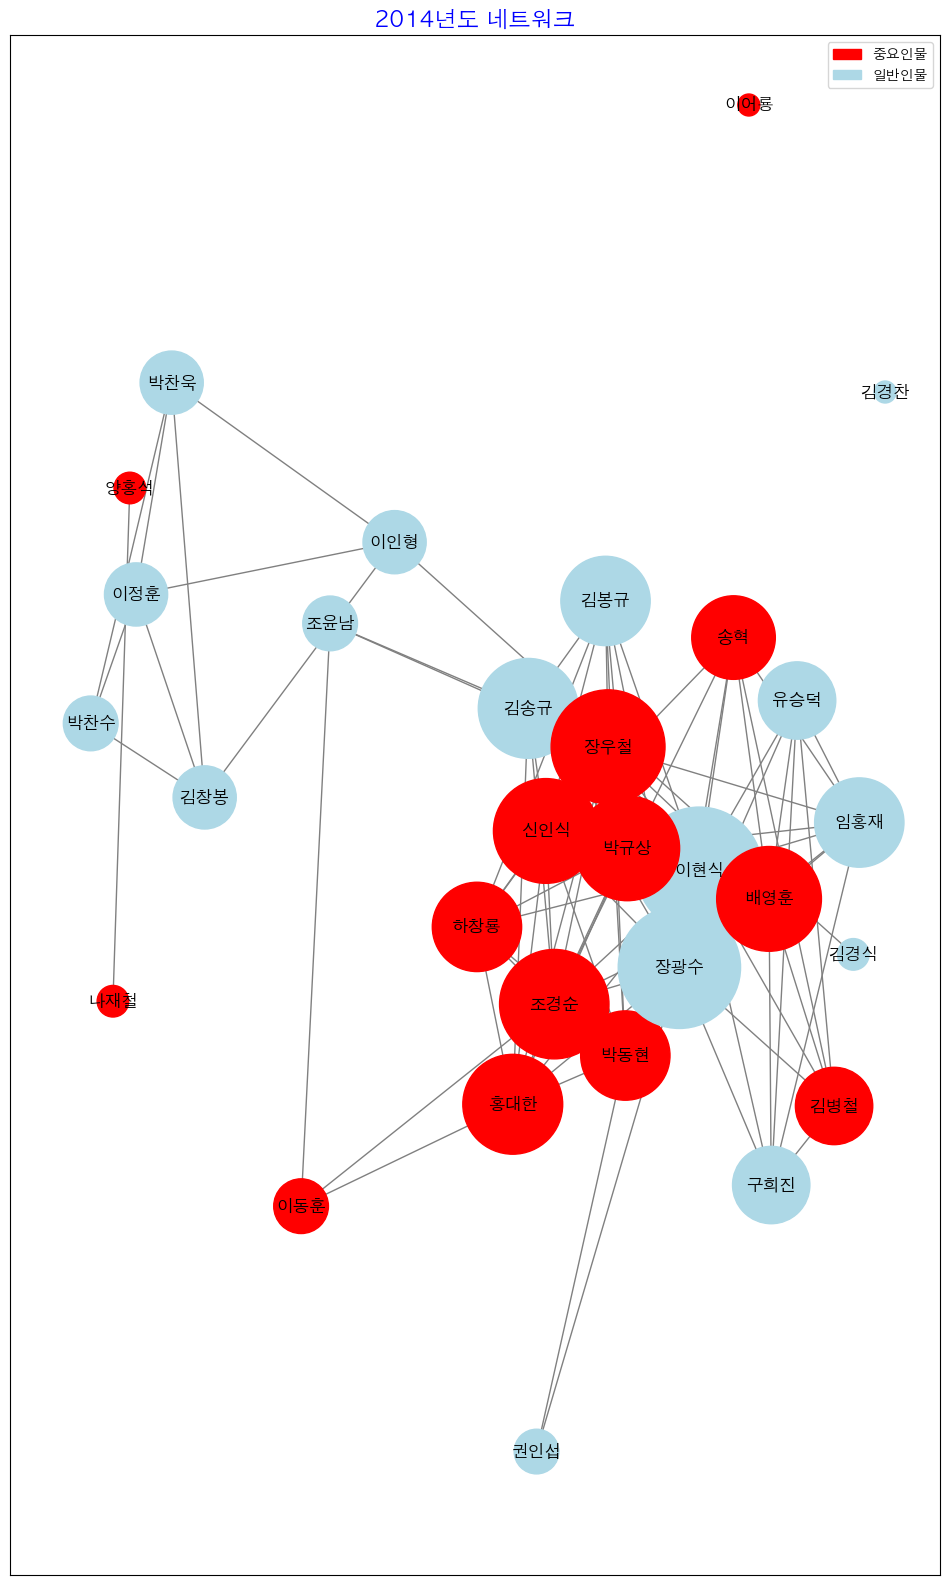

2014년도 네트워크 점수 계산

중요인물 연결 수
이현식 10
조경순 9
장광수 8
홍대한 7
신인식 7
장우철 7
하창룡 6
박규상 6
김송규 6
박동현 5
김봉규 5
배영훈 5
송혁 4
임홍재 4
조윤남 2
이동훈 2
구희진 2
유승덕 2
김병철 2
나재철 1
권인섭 1
양홍석 1
이정훈 0
박찬수 0
김경식 0
김경찬 0
이어룡 0
김창봉 0
박찬욱 0
이인형 0

Degree Centrality:
이현식 0.5517241379310345
장광수 0.5172413793103449
장우철 0.4482758620689655
조경순 0.41379310344827586
신인식 0.3793103448275862
박규상 0.3793103448275862
배영훈 0.3793103448275862
홍대한 0.3448275862068966
김송규 0.3448275862068966
하창룡 0.27586206896551724
박동현 0.27586206896551724
임홍재 0.27586206896551724
김봉규 0.27586206896551724
송혁 0.24137931034482757
구희진 0.20689655172413793
유승덕 0.20689655172413793
김병철 0.20689655172413793
이정훈 0.13793103448275862
김창봉 0.13793103448275862
박찬욱 0.13793103448275862
이인형 0.13793103448275862
조윤남 0.10344827586206896
이동훈 0.10344827586206896
박찬수 0.10344827586206896
권인섭 0.06896551724137931
나재철 0.034482758620689655
김경식 0.034482758620689655
양홍석 0.034482758620689655
김경찬 0.0
이어룡 0.0

Betweenness Centrality:
장광수 0.06426243433632596
이현식 0.05602293163869519
장우철 0.0342279231

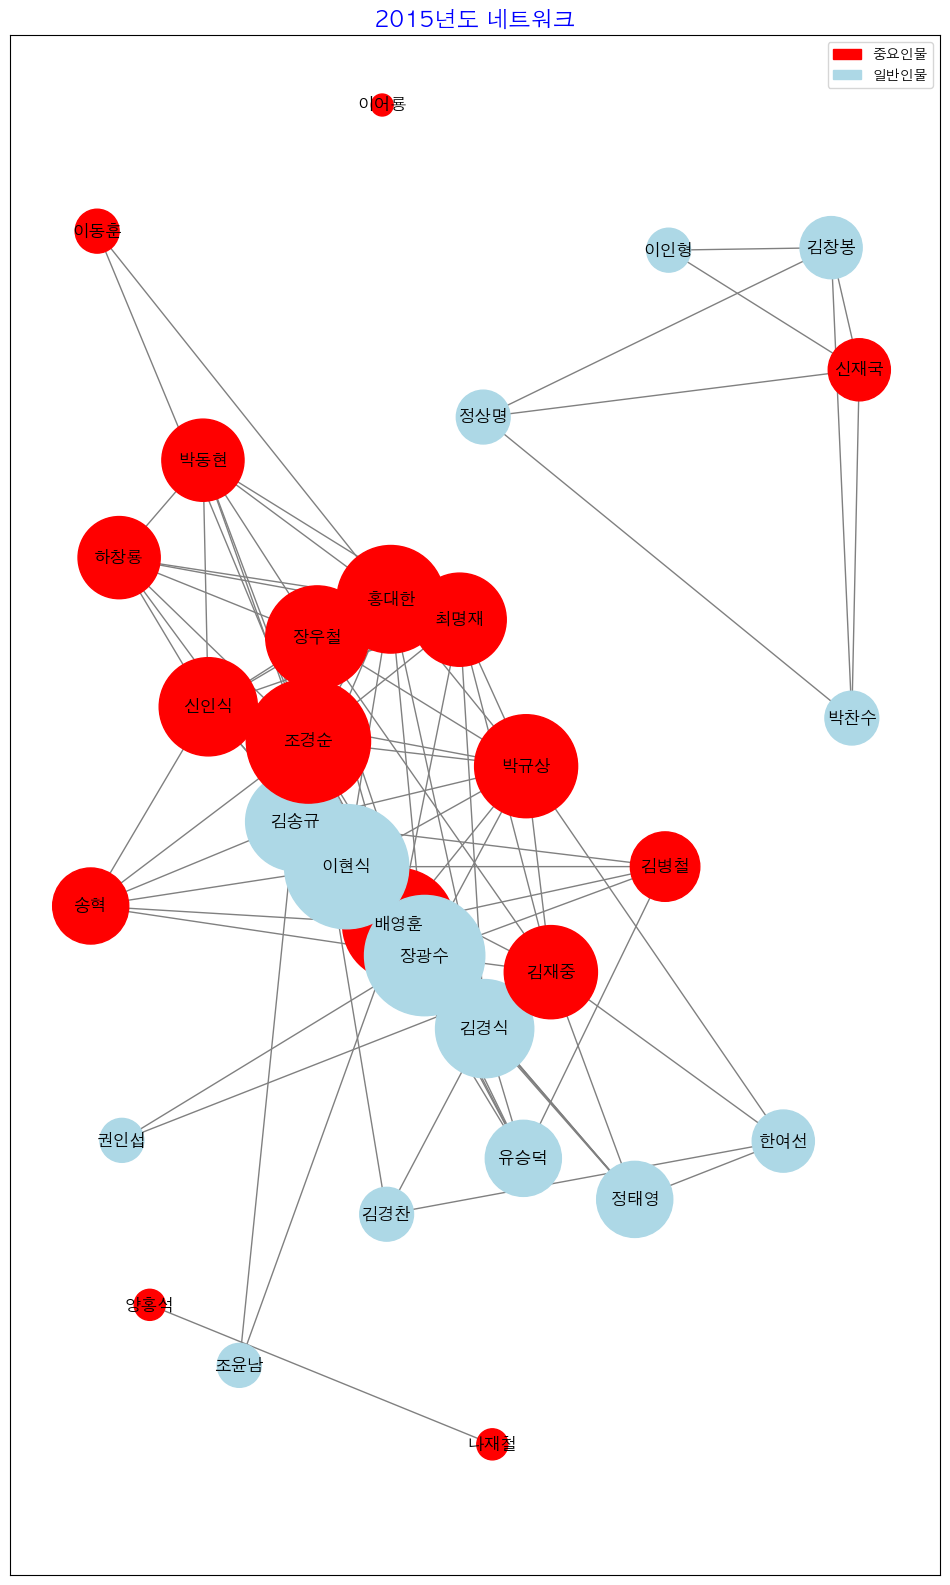

2015년도 네트워크 점수 계산

중요인물 연결 수
이현식 11
조경순 10
장광수 9
장우철 8
홍대한 8
신인식 8
최명재 8
박규상 7
김송규 7
하창룡 6
배영훈 6
박동현 6
김경식 5
유승덕 3
송혁 3
김재중 3
정태영 2
한여선 2
이동훈 2
정상명 1
김창봉 1
김경찬 1
김병철 1
양홍석 1
나재철 1
조윤남 1
권인섭 1
박찬수 1
이인형 1
이어룡 0
신재국 0

Degree Centrality:
이현식 0.5333333333333333
조경순 0.5333333333333333
장광수 0.5
배영훈 0.43333333333333335
홍대한 0.4
박규상 0.36666666666666664
장우철 0.36666666666666664
김송규 0.3333333333333333
김경식 0.3333333333333333
신인식 0.3333333333333333
김재중 0.3
최명재 0.3
하창룡 0.23333333333333334
박동현 0.23333333333333334
유승덕 0.2
정태영 0.2
송혁 0.2
김병철 0.16666666666666666
김창봉 0.13333333333333333
한여선 0.13333333333333333
신재국 0.13333333333333333
정상명 0.1
김경찬 0.1
박찬수 0.1
조윤남 0.06666666666666667
이동훈 0.06666666666666667
권인섭 0.06666666666666667
이인형 0.06666666666666667
양홍석 0.03333333333333333
나재철 0.03333333333333333
이어룡 0.0

Betweenness Centrality:
조경순 0.07749777042880493
장광수 0.06167006046316391
이현식 0.05215769543355749
배영훈 0.047488896799241634
박규상 0.02712703643738126
홍대한 0.02629463767394802
김송규 0.024584349239521658
김재중 0.0

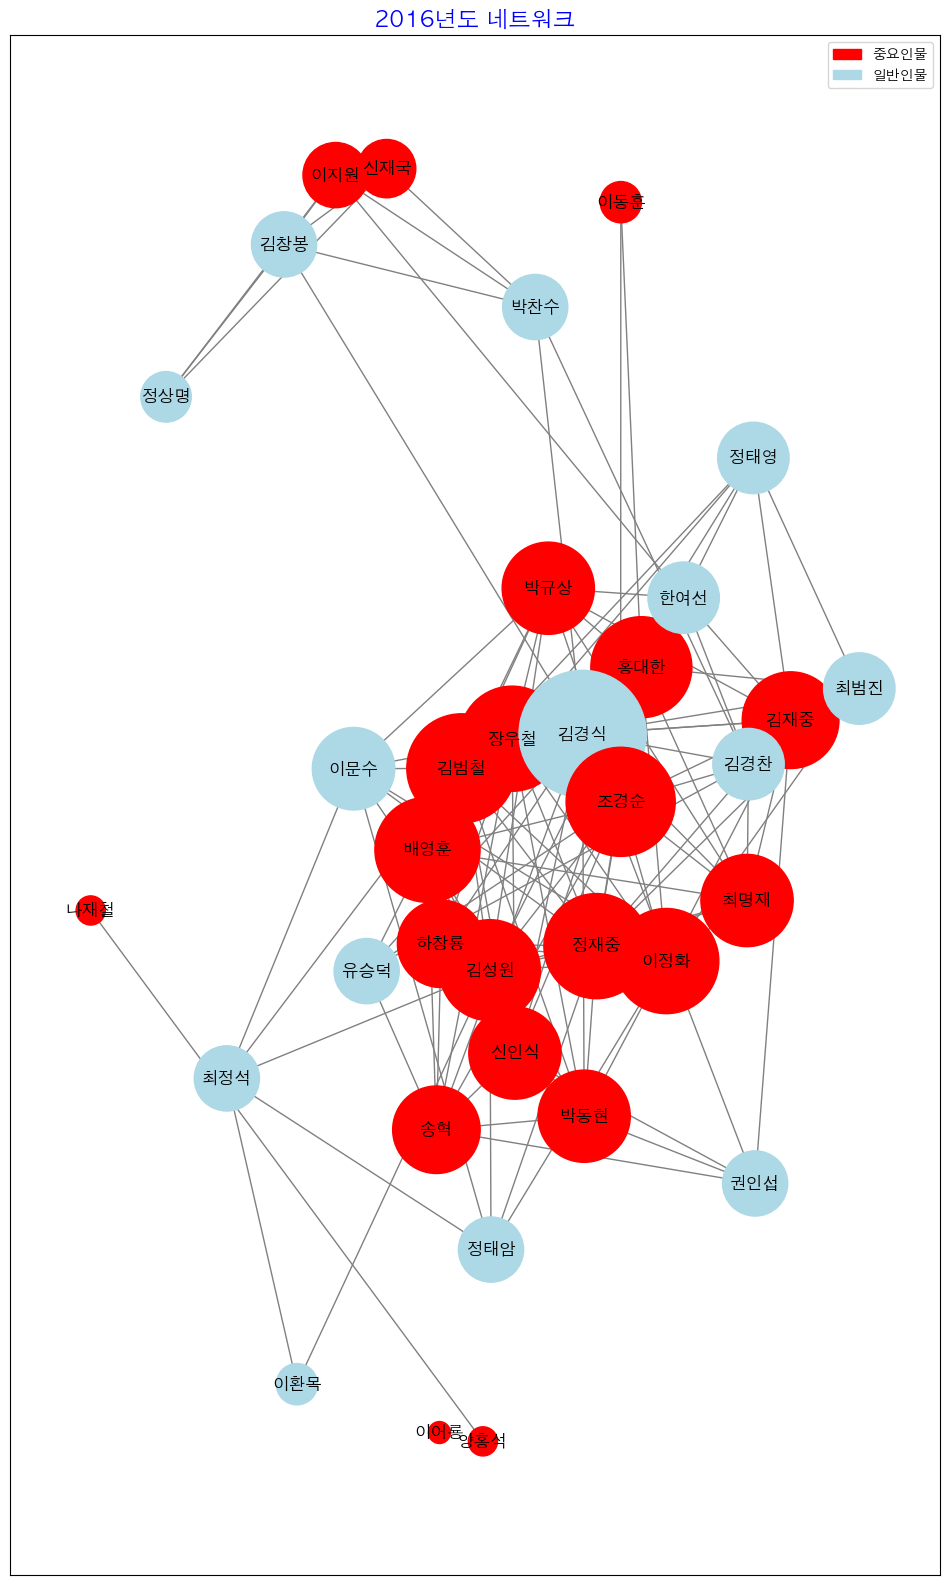

2016년도 네트워크 점수 계산

중요인물 연결 수
김경식 11
조경순 11
배영훈 11
이정화 10
홍대한 10
장우철 10
김범철 10
정재중 10
최명재 8
박동현 8
신인식 8
박규상 8
김성원 8
하창룡 8
송혁 6
김재중 6
이문수 6
권인섭 4
최범진 4
정태암 3
정태영 3
유승덕 3
한여선 3
김경찬 2
최정석 2
이동훈 2
정상명 2
박찬수 2
김창봉 2
신재국 1
나재철 1
이환목 1
양홍석 1
이지원 1
이어룡 0

Degree Centrality:
김경식 0.5588235294117647
김범철 0.4117647058823529
조경순 0.4117647058823529
이정화 0.38235294117647056
장우철 0.38235294117647056
정재중 0.38235294117647056
배영훈 0.38235294117647056
홍대한 0.3529411764705882
김성원 0.3529411764705882
김재중 0.3235294117647059
최명재 0.29411764705882354
박동현 0.29411764705882354
신인식 0.29411764705882354
박규상 0.29411764705882354
송혁 0.2647058823529412
하창룡 0.2647058823529412
이문수 0.23529411764705882
김경찬 0.1764705882352941
정태영 0.1764705882352941
한여선 0.1764705882352941
최범진 0.1764705882352941
정태암 0.14705882352941177
권인섭 0.14705882352941177
최정석 0.14705882352941177
유승덕 0.14705882352941177
박찬수 0.14705882352941177
김창봉 0.14705882352941177
이지원 0.14705882352941177
신재국 0.11764705882352941
정상명 0.08823529411764705
이환목 0.058823529411764705
이동

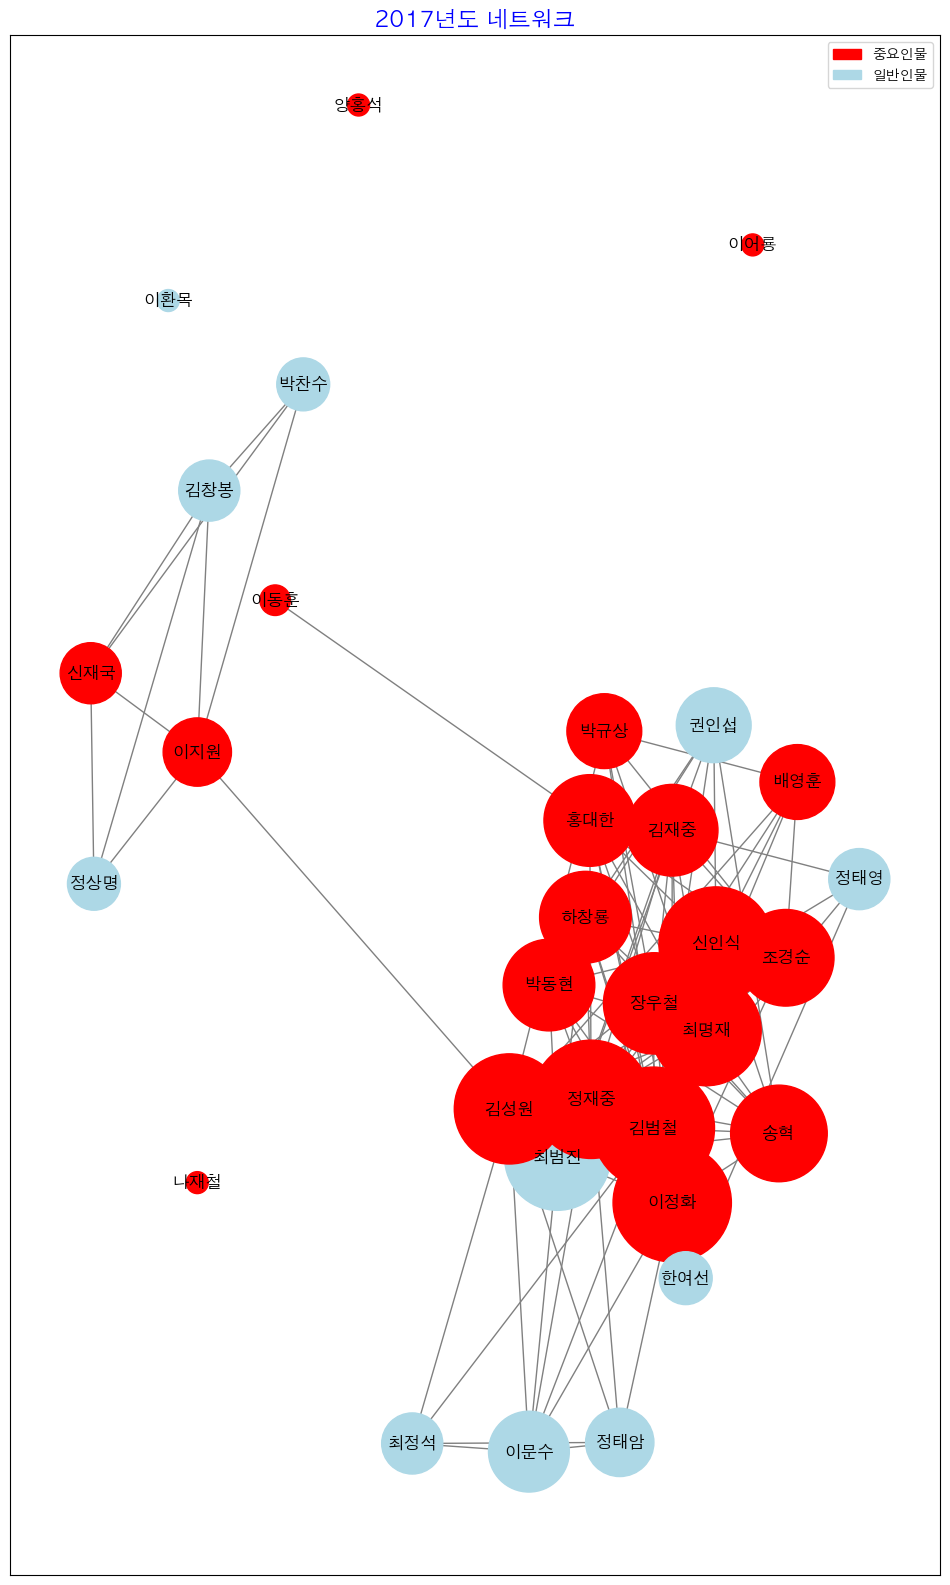

2017년도 네트워크 점수 계산

중요인물 연결 수
이정화 12
신인식 12
최명재 12
정재중 12
김범철 11
최범진 10
조경순 10
장우철 10
김성원 9
홍대한 9
송혁 8
박동현 7
하창룡 7
김재중 6
배영훈 6
박규상 5
권인섭 5
이문수 4
정태영 3
정태암 3
김창봉 2
이지원 2
최정석 2
정상명 2
박찬수 2
한여선 2
이동훈 1
신재국 1
이어룡 0
이환목 0
나재철 0
양홍석 0

Degree Centrality:
김범철 0.5161290322580645
이정화 0.4838709677419355
정재중 0.4838709677419355
신인식 0.45161290322580644
김성원 0.4193548387096774
최명재 0.4193548387096774
최범진 0.3870967741935484
장우철 0.3548387096774194
조경순 0.3225806451612903
송혁 0.3225806451612903
박동현 0.29032258064516125
김재중 0.29032258064516125
하창룡 0.29032258064516125
홍대한 0.29032258064516125
이문수 0.22580645161290322
배영훈 0.1935483870967742
박규상 0.1935483870967742
권인섭 0.1935483870967742
정태암 0.16129032258064516
이지원 0.16129032258064516
정태영 0.12903225806451613
김창봉 0.12903225806451613
최정석 0.12903225806451613
신재국 0.12903225806451613
정상명 0.0967741935483871
박찬수 0.0967741935483871
한여선 0.0967741935483871
이동훈 0.03225806451612903
이어룡 0.0
이환목 0.0
나재철 0.0
양홍석 0.0

Betweenness Centrality:
김성원 0.26788886880917245
이지원 0.198566308

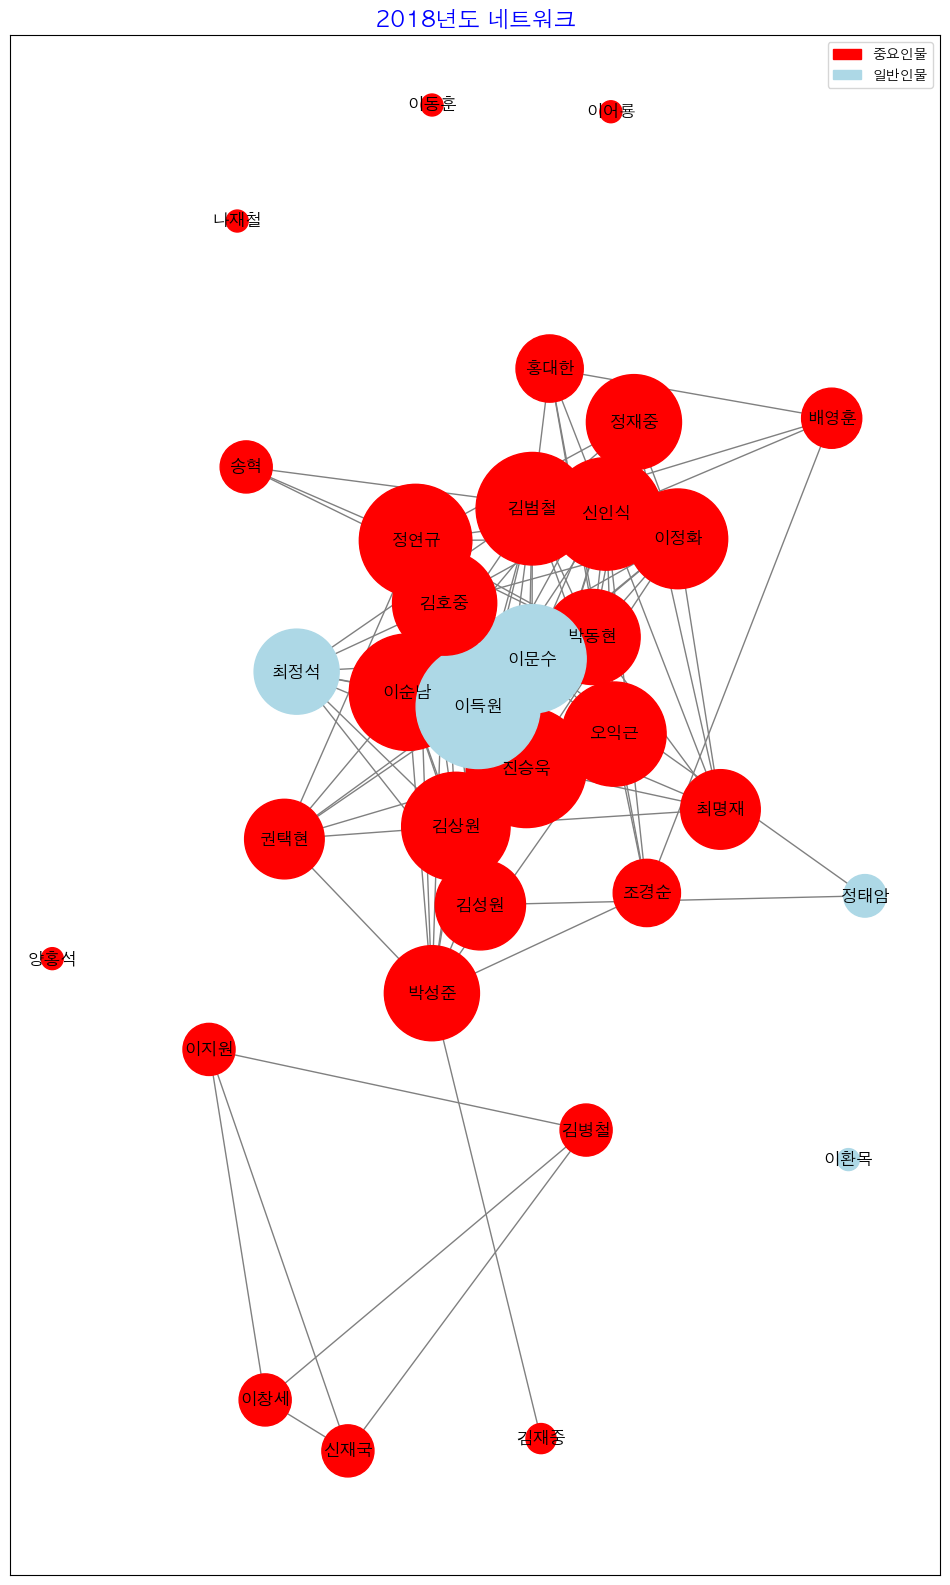

2018년도 네트워크 점수 계산

중요인물 연결 수
이득원 15
진승욱 13
신인식 13
이순남 12
정연규 12
오익근 11
김범철 11
김상원 10
이문수 10
박성준 9
박동현 9
김호중 9
이정화 9
정재중 8
최정석 6
최명재 6
조경순 5
김성원 5
권택현 5
홍대한 5
배영훈 4
김병철 3
이창세 3
이지원 3
송혁 3
신재국 3
정태암 1
김재중 1
이환목 0
이어룡 0
양홍석 0
이동훈 0
나재철 0

Degree Centrality:
이득원 0.53125
진승욱 0.5
이순남 0.46875
정연규 0.4375
신인식 0.4375
김범철 0.4375
김상원 0.40625
이문수 0.40625
오익근 0.375
김호중 0.375
이정화 0.34375
박성준 0.3125
박동현 0.3125
정재중 0.3125
김성원 0.28125
최정석 0.25
권택현 0.21875
최명재 0.21875
조경순 0.15625
홍대한 0.15625
배영훈 0.125
김병철 0.09375
이창세 0.09375
이지원 0.09375
송혁 0.09375
신재국 0.09375
정태암 0.0625
김재중 0.03125
이환목 0.0
이어룡 0.0
양홍석 0.0
이동훈 0.0
나재철 0.0

Betweenness Centrality:
박성준 0.05459654174900442
신인식 0.05028130448784685
김범철 0.044560773460513584
이문수 0.033991976885122045
정연규 0.03200907782999297
이득원 0.030582004020922017
진승욱 0.025567529248382726
오익근 0.022077236984087704
이순남 0.019982997739319414
김상원 0.015486956146503623
김성원 0.014902906233551396
김호중 0.011529830835684313
박동현 0.008923832663752018
조경순 0.007582885304659498
이정화 0.004615220275

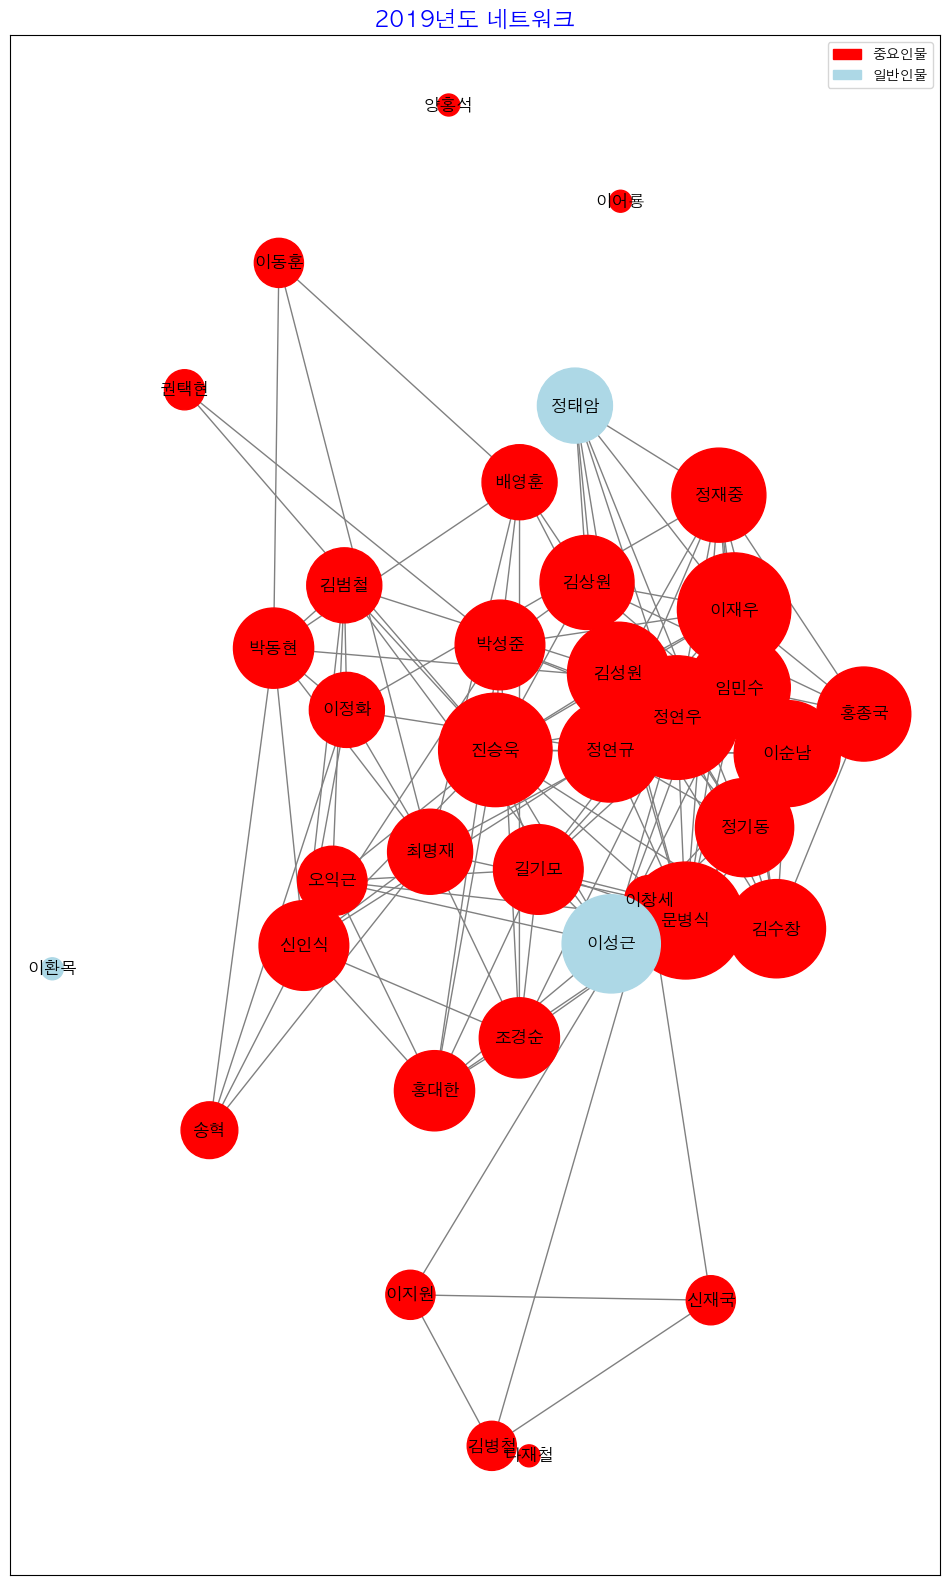

2019년도 네트워크 점수 계산

중요인물 연결 수
정연우 17
문병식 16
진승욱 15
이재우 14
이순남 13
정연규 12
김성원 12
임민수 12
이성근 12
정기동 11
김수창 11
정재중 10
박성준 10
홍종국 10
신인식 10
김상원 10
최명재 9
길기모 9
박동현 8
조경순 8
정태암 7
배영훈 7
홍대한 7
이정화 7
김범철 6
오익근 5
송혁 4
신재국 3
김병철 3
이동훈 3
이지원 3
이창세 3
권택현 2
이환목 0
양홍석 0
이어룡 0
나재철 0

Degree Centrality:
정연우 0.5277777777777778
문병식 0.4722222222222222
진승욱 0.4444444444444444
이재우 0.4444444444444444
이순남 0.38888888888888884
정연규 0.3611111111111111
김성원 0.3611111111111111
임민수 0.3611111111111111
정기동 0.3333333333333333
김수창 0.3333333333333333
이성근 0.3333333333333333
정재중 0.3055555555555555
홍종국 0.3055555555555555
김상원 0.3055555555555555
박성준 0.2777777777777778
길기모 0.2777777777777778
신인식 0.2777777777777778
최명재 0.25
박동현 0.2222222222222222
조경순 0.2222222222222222
홍대한 0.2222222222222222
정태암 0.19444444444444442
배영훈 0.19444444444444442
김범철 0.19444444444444442
이정화 0.19444444444444442
오익근 0.16666666666666666
송혁 0.1111111111111111
신재국 0.08333333333333333
김병철 0.08333333333333333
이동훈 0.08333333333333333
이지원 0.08333333333333333
이창세 0.

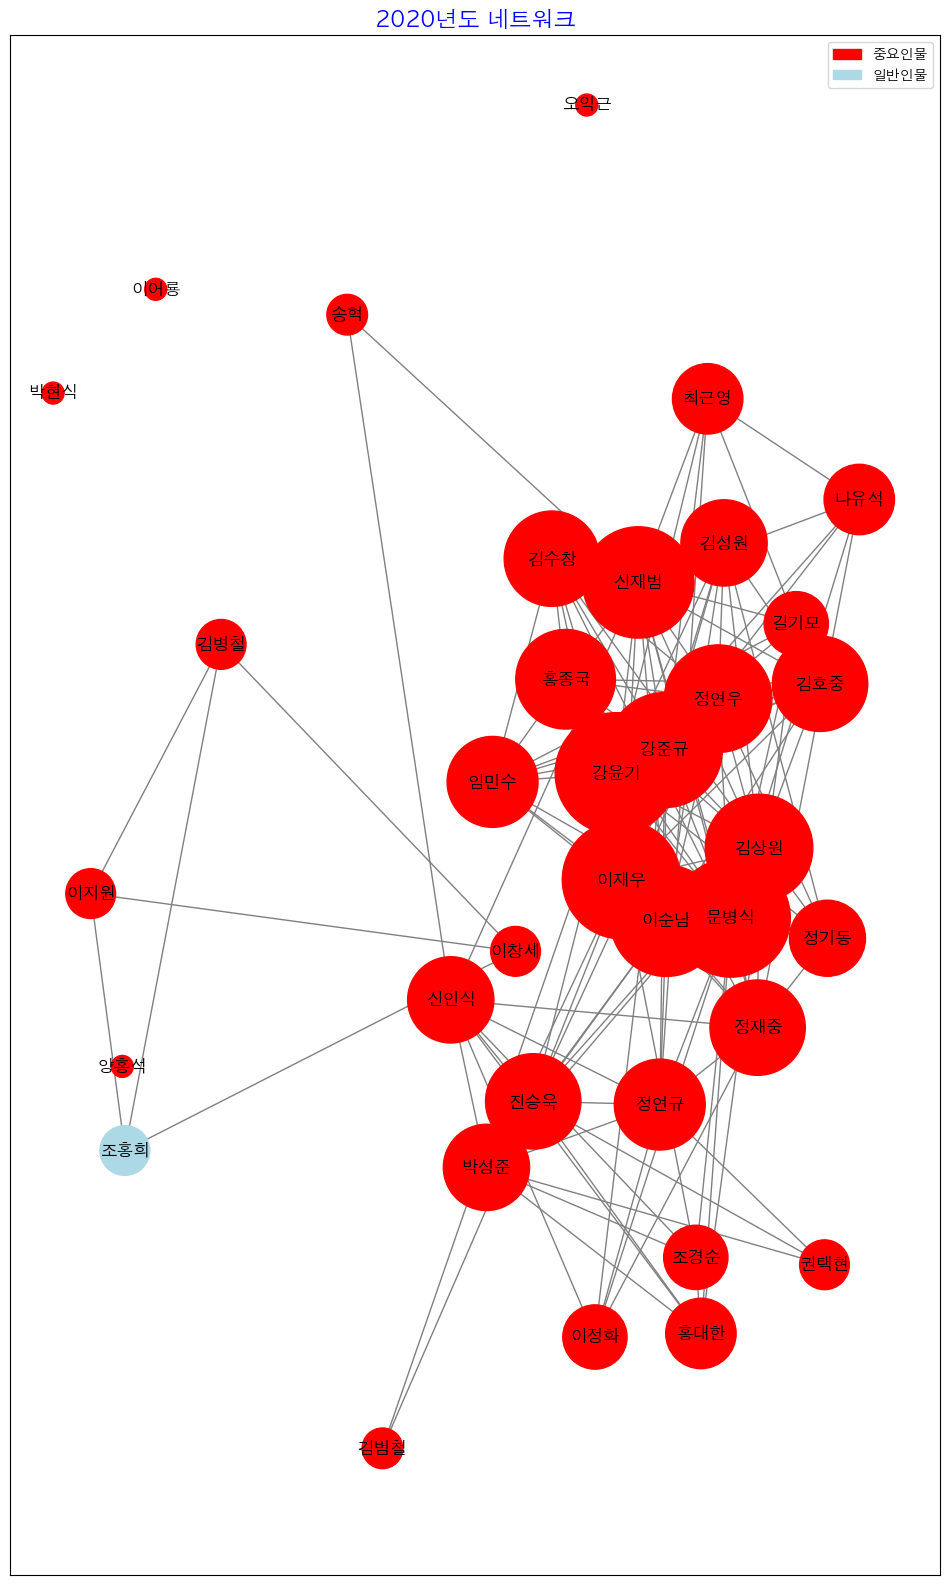

2020년도 네트워크 점수 계산

중요인물 연결 수
강윤기 18
이재우 17
문병식 17
강준규 16
이순남 15
신재범 15
김상원 14
정연우 14
홍종국 12
진승욱 11
정재중 11
김호중 11
김수창 11
정연규 10
임민수 10
신인식 9
김성원 9
박성준 9
정기동 7
나유석 6
최근영 6
홍대한 6
이정화 5
길기모 5
조경순 5
권택현 3
조홍희 3
김병철 2
송혁 2
김범철 2
이창세 2
이지원 2
오익근 0
박현식 0
이어룡 0
양홍석 0

Degree Centrality:
강윤기 0.5142857142857142
이재우 0.4857142857142857
문병식 0.4857142857142857
강준규 0.45714285714285713
이순남 0.42857142857142855
신재범 0.42857142857142855
김상원 0.39999999999999997
정연우 0.39999999999999997
홍종국 0.34285714285714286
진승욱 0.3142857142857143
정재중 0.3142857142857143
김호중 0.3142857142857143
김수창 0.3142857142857143
정연규 0.2857142857142857
임민수 0.2857142857142857
신인식 0.2571428571428571
김성원 0.2571428571428571
박성준 0.2571428571428571
정기동 0.19999999999999998
나유석 0.17142857142857143
최근영 0.17142857142857143
홍대한 0.17142857142857143
이정화 0.14285714285714285
길기모 0.14285714285714285
조경순 0.14285714285714285
김병철 0.08571428571428572
권택현 0.08571428571428572
이창세 0.08571428571428572
이지원 0.08571428571428572
조홍희 0.08571428571428572
송혁 0.05714285

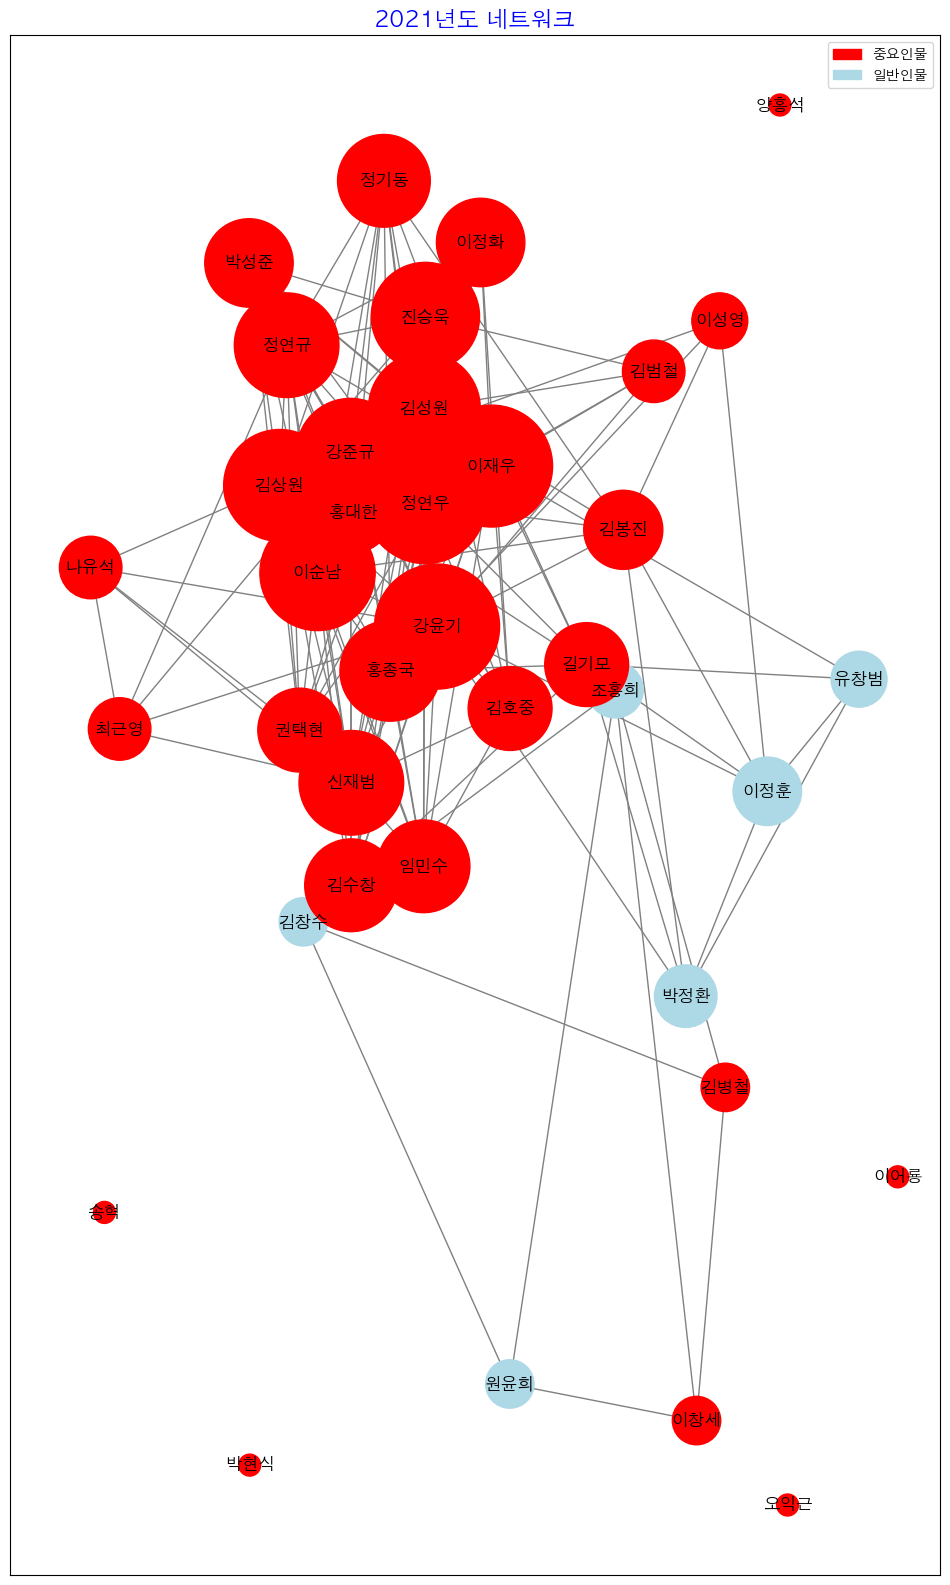

2021년도 네트워크 점수 계산

중요인물 연결 수
정연우 19
이재우 18
강윤기 18
이순남 17
김성원 16
김상원 16
강준규 15
진승욱 15
정연규 14
신재범 14
홍종국 13
정기동 11
임민수 11
김수창 11
이정화 10
박성준 10
김호중 9
권택현 9
홍대한 8
김봉진 6
길기모 6
김범철 5
최근영 5
나유석 5
이정훈 4
이성영 3
박정환 3
조홍희 2
유창범 2
김병철 1
원윤희 1
이창세 1
김창수 1
이어룡 0
양홍석 0
박현식 0
오익근 0
송혁 0

Degree Centrality:
강윤기 0.5405405405405406
정연우 0.5135135135135136
이재우 0.5135135135135136
이순남 0.4594594594594595
김성원 0.43243243243243246
김상원 0.43243243243243246
강준규 0.40540540540540543
진승욱 0.40540540540540543
정연규 0.3783783783783784
신재범 0.3783783783783784
홍종국 0.35135135135135137
정기동 0.2972972972972973
임민수 0.2972972972972973
김수창 0.2972972972972973
이정화 0.2702702702702703
박성준 0.2702702702702703
김호중 0.24324324324324326
길기모 0.24324324324324326
권택현 0.24324324324324326
김봉진 0.21621621621621623
홍대한 0.21621621621621623
이정훈 0.16216216216216217
김범철 0.13513513513513514
박정환 0.13513513513513514
최근영 0.13513513513513514
나유석 0.13513513513513514
이성영 0.10810810810810811
조홍희 0.10810810810810811
유창범 0.10810810810810811
김병철 0.08108108108108109

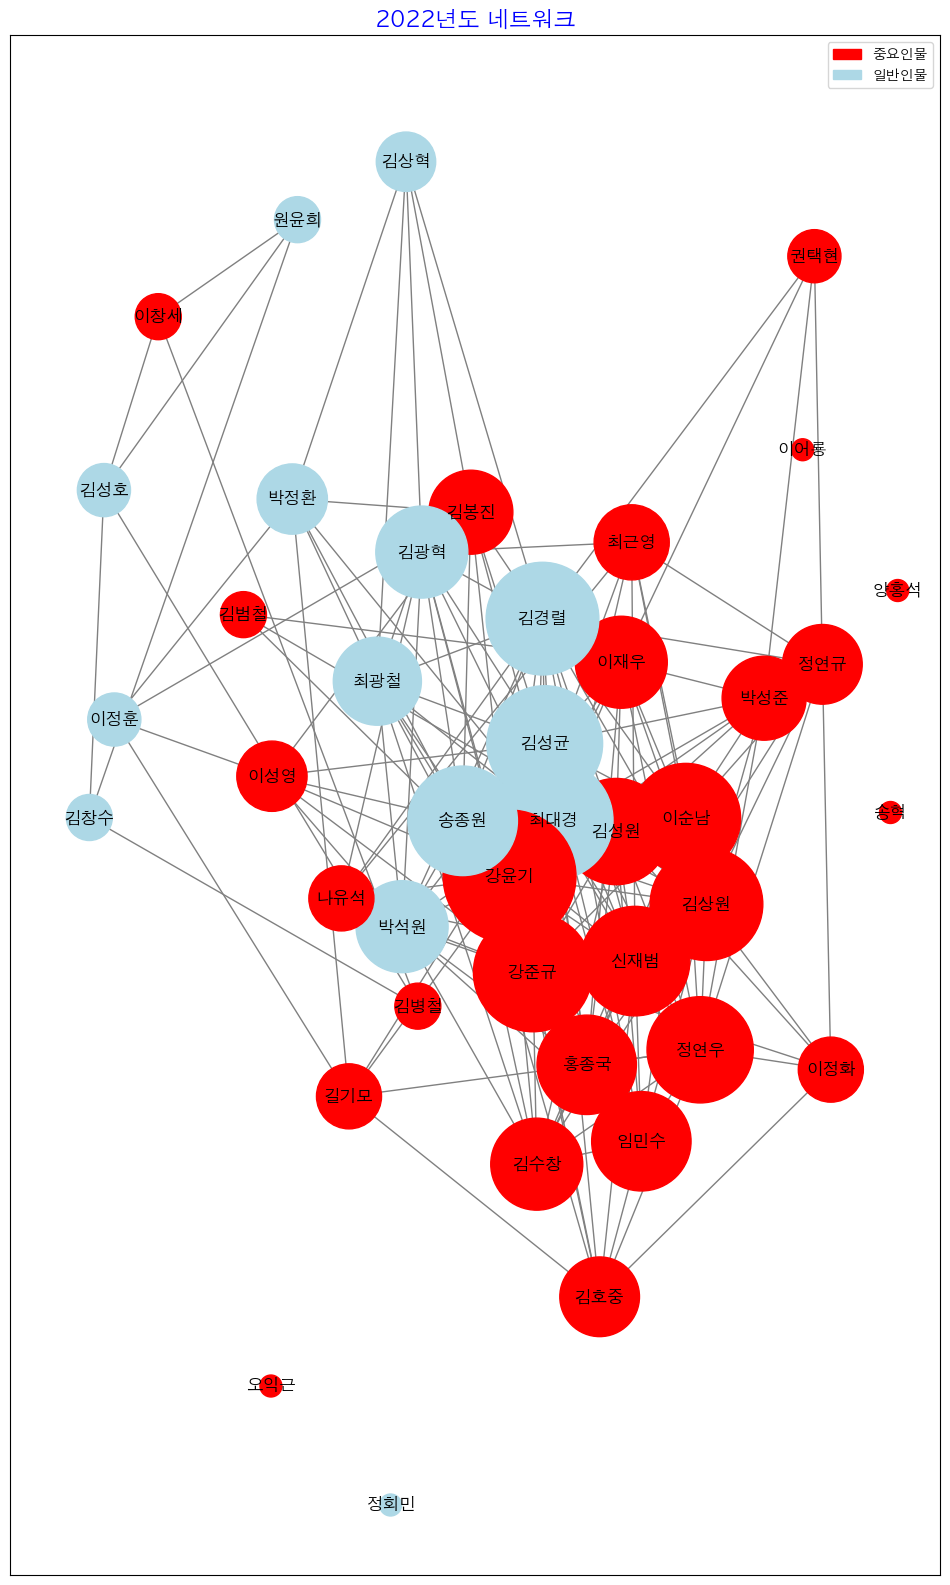

2022년도 네트워크 점수 계산

중요인물 연결 수
강윤기 18
정연우 14
김상원 14
강준규 13
이순남 13
김성균 13
김성원 13
최대경 13
신재범 13
김경렬 11
이재우 10
홍종국 10
임민수 10
송종원 10
김수창 9
정연규 8
박성준 8
최근영 7
김호중 7
이정화 6
박석원 6
김광혁 5
길기모 4
나유석 4
최광철 3
권택현 3
이정훈 3
이성영 3
김범철 3
박정환 2
김성호 2
김봉진 2
김병철 1
김상혁 1
이창세 1
김창수 1
원윤희 1
송혁 0
정회민 0
오익근 0
이어룡 0
양홍석 0

Degree Centrality:
강윤기 0.6097560975609756
강준규 0.4878048780487805
최대경 0.4878048780487805
김성균 0.4634146341463415
김상원 0.43902439024390244
김경렬 0.43902439024390244
이순남 0.41463414634146345
신재범 0.41463414634146345
송종원 0.41463414634146345
정연우 0.3902439024390244
김성원 0.3902439024390244
홍종국 0.34146341463414637
임민수 0.34146341463414637
이재우 0.29268292682926833
김수창 0.29268292682926833
박석원 0.29268292682926833
김광혁 0.29268292682926833
최광철 0.2682926829268293
김봉진 0.24390243902439024
박성준 0.24390243902439024
정연규 0.21951219512195122
김호중 0.21951219512195122
최근영 0.1951219512195122
박정환 0.17073170731707318
이성영 0.17073170731707318
이정화 0.14634146341463417
길기모 0.14634146341463417
나유석 0.14634146341463417
김상혁 0.1219512195121951

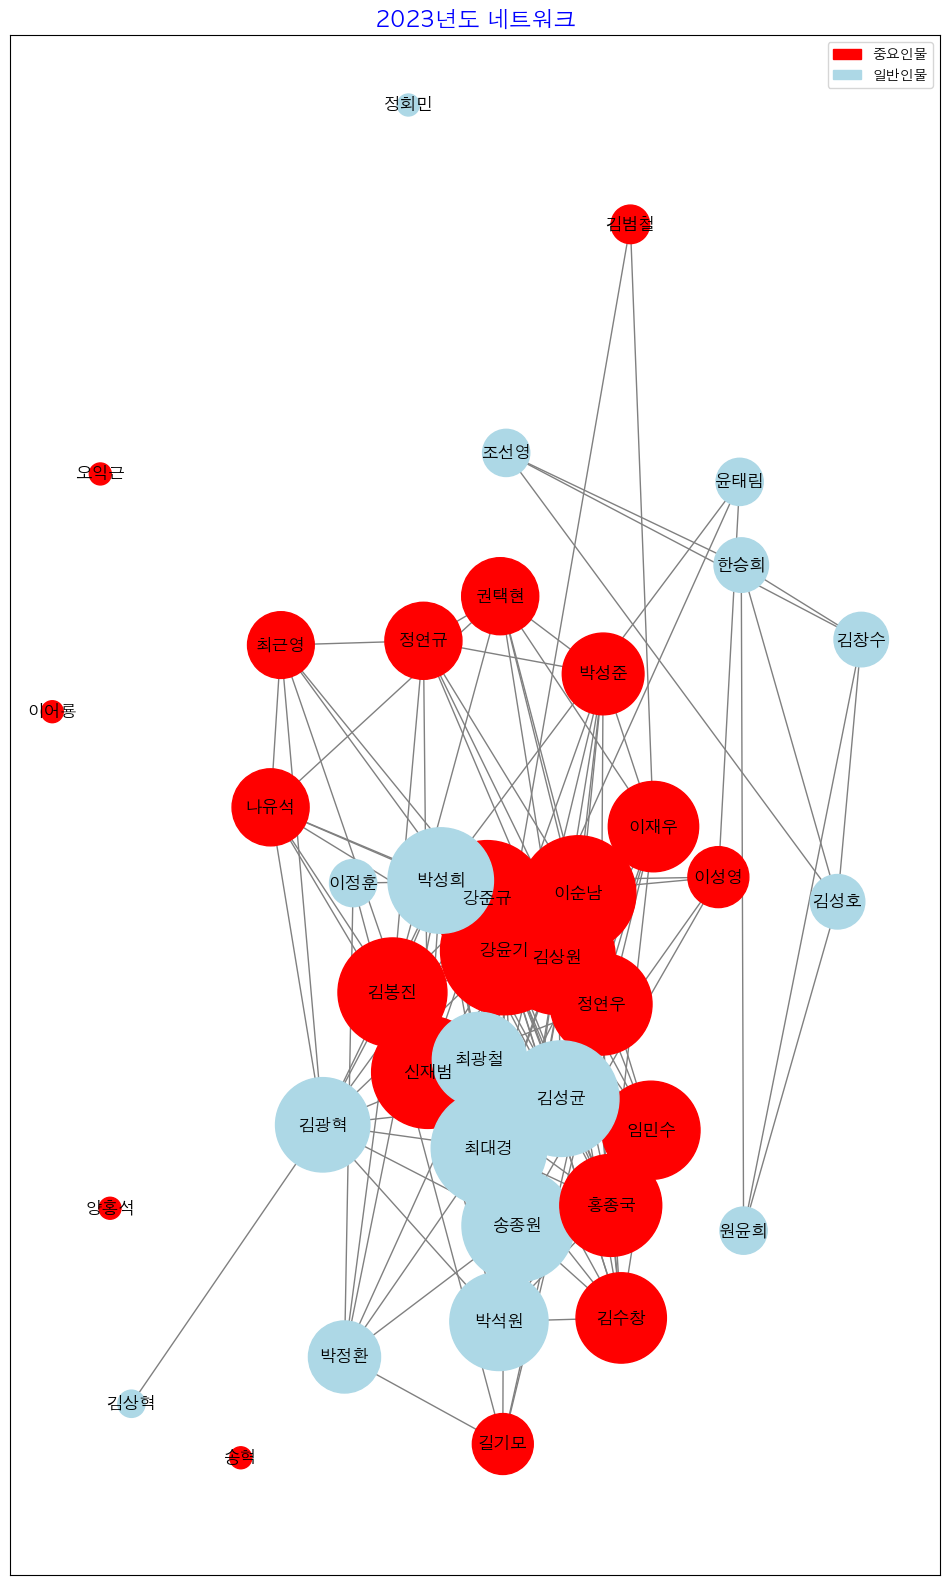

2023년도 네트워크 점수 계산

중요인물 연결 수
강윤기 15
이순남 13
김상원 13
신재범 12
정연우 12
김성균 12
강준규 11
최대경 11
송종원 10
김봉진 9
이재우 9
임민수 9
홍종국 9
권택현 8
박석원 8
박성희 8
정연규 8
김수창 8
박성준 7
나유석 6
최근영 5
김광혁 5
최광철 4
길기모 3
박정환 2
이정훈 2
김범철 2
이성영 1
윤태림 1
김성호 0
양홍석 0
정회민 0
송혁 0
김창수 0
김상혁 0
조선영 0
원윤희 0
오익근 0
이어룡 0
한승희 0

Degree Centrality:
강윤기 0.5641025641025641
강준규 0.4615384615384615
이순남 0.4615384615384615
최대경 0.4615384615384615
김상원 0.4615384615384615
김성균 0.4615384615384615
신재범 0.4358974358974359
송종원 0.4358974358974359
김봉진 0.41025641025641024
박성희 0.3846153846153846
정연우 0.358974358974359
홍종국 0.358974358974359
박석원 0.3333333333333333
임민수 0.3333333333333333
최광철 0.3076923076923077
김광혁 0.3076923076923077
이재우 0.28205128205128205
김수창 0.28205128205128205
박성준 0.23076923076923075
권택현 0.20512820512820512
나유석 0.20512820512820512
정연규 0.20512820512820512
박정환 0.1794871794871795
최근영 0.15384615384615385
이성영 0.1282051282051282
길기모 0.1282051282051282
김성호 0.10256410256410256
김창수 0.10256410256410256
한승희 0.10256410256410256
조선영 0.07692307692307693
원윤희

In [176]:
result_dict_all_year = print_network(matrixs)

### 가중합 선정

In [177]:
#weights 값 임의로 설정
def weighted_average_values(result_dict, weights = [1.5, 2.5, 3.5, 1, 1.5], rank = 5):
    # 각 키에 해당하는 값들을 가중 평균하여 하나의 값으로 계산
    weighted_values = []
    for values in result_dict.values():
        weighted_value = sum(value * weight for value, weight in zip(values, weights))
        weighted_values.append(weighted_value)
            
    weighted_dict = {}
    keys = list(result_dict.keys())
    for i, key in enumerate(keys):
        weighted_dict[key] = weighted_values[i]

    sorted_items = sorted(weighted_dict.items(), key=lambda x: x[1], reverse=True)
    top_values = sorted_items[:rank]
    top_dict = {key: value for key, value in top_values}

    bottom_values = sorted_items[-rank:]
    bottom_dict = {key: value for key, value in bottom_values}

    for key in top_dict:
        top_dict[key] *= 100

    for key in bottom_dict:
        bottom_dict[key] *= 100
    
    return top_dict, bottom_dict

def cal_weight(weights):
    top = {}
    bottom = {}
    for year in YEAR_LIST:
        # 속성별 가중치 값
        top_dict, bottom_dict = weighted_average_values(result_dict_all_year[year], weights)  
        top[year] = top_dict
        bottom[year] = bottom_dict
        
    return top, bottom

top, bottom = cal_weight([1.5, 2.5, 3.5, 1, 1.5])


## 중요인물 검증

In [178]:
top

{2014: {'이현식': 955.1242343376243,
  '장광수': 936.7847095601826,
  '장우철': 712.8468791224958,
  '조경순': 694.409584211351,
  '홍대한': 537.033626732275},
 2015: {'조경순': 981.8682076993352,
  '이현식': 885.5576592815102,
  '장광수': 870.238640257638,
  '배영훈': 708.8764238735955,
  '홍대한': 623.1225845477787},
 2016: {'김경식': 1000.0,
  '조경순': 648.4900270322439,
  '김범철': 638.2723626710452,
  '배영훈': 579.3537129353339,
  '장우철': 561.3146711708378},
 2017: {'김성원': 877.9533997286048,
  '김범철': 762.7965729646974,
  '이정화': 690.7632270939869,
  '정재중': 690.7632270939869,
  '신인식': 655.3625658712757},
 2018: {'신인식': 847.7797167923168,
  '이득원': 846.0509047721487,
  '김범철': 807.3292601641072,
  '진승욱': 768.9898372296818,
  '박성준': 750.5685292987162},
 2019: {'정연우': 1000.0,
  '진승욱': 868.3721394132688,
  '문병식': 783.5178377985327,
  '이재우': 656.2844887912939,
  '정연규': 623.1817567520892},
 2020: {'강윤기': 999.4344915905274,
  '문병식': 911.2080311641639,
  '이재우': 832.7781635926414,
  '신재범': 822.720905098852,
  '강준규': 765.056360871585}

In [179]:
bottom

{2014: {'나재철': 36.719182828743506,
  '양홍석': 36.719182828743506,
  '김경식': 30.860586571483527,
  '김경찬': 0.0,
  '이어룡': 0.0},
 2015: {'정상명': 79.02410862216264,
  '이인형': 60.313604373503374,
  '나재철': 35.04648761928703,
  '양홍석': 35.04648761928703,
  '이어룡': 0.0},
 2016: {'정상명': 117.42351906089885,
  '이환목': 104.75887764649863,
  '나재철': 31.47688064197045,
  '양홍석': 31.47688064197045,
  '이어룡': 0.0},
 2017: {'이동훈': 89.21611138392585,
  '나재철': 0.0,
  '양홍석': 0.0,
  '이어룡': 0.0,
  '이환목': 0.0},
 2018: {'나재철': 0.0, '양홍석': 0.0, '이동훈': 0.0, '이어룡': 0.0, '이환목': 0.0},
 2019: {'이창세': 80.10243726830822,
  '나재철': 0.0,
  '양홍석': 0.0,
  '이어룡': 0.0,
  '이환목': 0.0},
 2020: {'이창세': 73.14815416542886,
  '박현식': 0.0,
  '양홍석': 0.0,
  '오익근': 0.0,
  '이어룡': 0.0},
 2021: {'박현식': 0.0, '송혁': 0.0, '양홍석': 0.0, '오익근': 0.0, '이어룡': 0.0},
 2022: {'송혁': 0.0, '양홍석': 0.0, '오익근': 0.0, '이어룡': 0.0, '정회민': 0.0},
 2023: {'송혁': 0.0, '양홍석': 0.0, '오익근': 0.0, '이어룡': 0.0, '정회민': 0.0}}

In [180]:
def verification(top):
    IP = {}
    num = 0
    
    for year in top.keys():
        dict = {}
        for name in top[year]:
            
            temp = df.loc[df['이름'] == name]
            promoted_this_year = False
            promoted_next_year = False
            last_this_IP_select = False
            verify = False
            
            now_position = temp.loc[temp['연도']==year,'직위'].values[0]
        
            #이전년도 데이터 존재
            if(year-1 in temp['연도'].values):
                last_position =temp.loc[temp['연도']==year-1,'직위'].values[0]
                if(name in list(IP[year-1].keys())):
                    last_this_IP_select = True
                if(last_position != now_position):
                    promoted_this_year = True
            
            #다음년도 데이터 존재
            if(year+1 in temp['연도'].values):
                next_position = temp.loc[temp['연도']==year+1,'직위'].values[0]
                if(next_position != now_position):
                    promoted_next_year = True
            
            if(promoted_next_year | promoted_this_year | last_this_IP_select):
                verify = True
                num += 1
            
            dict[name] = verify
            
        IP[year] = dict
    
    score = num / (len(top) * 5)
    return IP, score

In [181]:
IP, score = verification(top)

In [182]:
IP

{2014: {'이현식': False, '장광수': False, '장우철': False, '조경순': False, '홍대한': False},
 2015: {'조경순': True, '이현식': True, '장광수': True, '배영훈': False, '홍대한': True},
 2016: {'김경식': False, '조경순': True, '김범철': False, '배영훈': True, '장우철': True},
 2017: {'김성원': False, '김범철': True, '이정화': False, '정재중': False, '신인식': False},
 2018: {'신인식': True, '이득원': False, '김범철': True, '진승욱': True, '박성준': True},
 2019: {'정연우': False, '진승욱': True, '문병식': False, '이재우': False, '정연규': True},
 2020: {'강윤기': False, '문병식': True, '이재우': True, '신재범': False, '강준규': False},
 2021: {'강윤기': True, '이재우': True, '정연우': True, '이순남': False, '강준규': True},
 2022: {'강윤기': True, '김경렬': False, '최대경': False, '강준규': True, '김성균': False},
 2023: {'강윤기': True, '김성균': True, '강준규': True, '최대경': True, '김상원': False}}

In [183]:
score

0.52

## 최적화

### 1

In [136]:
import itertools

In [137]:
YEAR_LIST = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

def grid_search(grid_weights):
    best_weights = None
    best_score = float('-inf')
    
    # 모든 가중치 조합 탐색
    for weights in itertools.product(*grid_weights):
        top, bottom = cal_weight(weights)
        
        IP, score = verification(top)
        
        if score > best_score:
            best_weights = weights
            best_score = score

    return best_weights


grid_weights = [[0.1, 0.5, 1, 1.5, 2, 2.5, 3.0], [0.1, 0.5, 1, 1.5, 2, 2.5, 3.0], [0.1, 0.5, 1, 1.5, 2, 2.5, 3.0], [0.1, 0.5, 1, 1.5, 2, 2.5, 3.0], [0.1, 0.5, 1, 1.5, 2, 2.5, 3.0,]]
best_weights = grid_search(grid_weights)

In [138]:
best_weights

(0.1, 0.1, 1, 2, 0.1)

(0.1, 0.1, 1, 2, 0.1)

In [139]:
top, bottom = cal_weight(best_weights)
    
IP, score = verification(top)

In [140]:
IP

{2014: {'장광수': False, '이현식': False, '장우철': False, '조경순': False, '배영훈': False},
 2015: {'조경순': True, '장광수': True, '이현식': True, '배영훈': True, '홍대한': False},
 2016: {'김경식': False, '조경순': True, '김범철': False, '배영훈': True, '홍대한': True},
 2017: {'김성원': False, '김범철': True, '이정화': False, '정재중': False, '신인식': False},
 2018: {'신인식': True, '이득원': False, '김범철': True, '박성준': True, '진승욱': True},
 2019: {'정연우': False, '진승욱': True, '문병식': False, '신인식': True, '정연규': True},
 2020: {'강윤기': False, '문병식': True, '이재우': True, '신재범': False, '강준규': False},
 2021: {'강윤기': True, '이재우': True, '정연우': True, '이순남': False, '강준규': True},
 2022: {'강윤기': True, '김경렬': False, '최대경': False, '강준규': True, '김성균': False},
 2023: {'강윤기': True, '김성균': True, '강준규': True, '최대경': True, '김봉진': True}}

In [141]:
score

0.56

### 2

In [143]:
YEAR_LIST = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

grid_weights = [[0.1, 0.3, 0.5, 0.7, 0.9], [0.1, 0.3, 0.5, 0.7, 0.9], [0.1, 0.3, 0.5, 0.7, 0.9], [0.1, 0.3, 0.5, 0.7, 0.9], [0.1, 0.3, 0.5, 0.7, 0.9]]
best_weights = grid_search(grid_weights)

In [144]:
best_weights

(0.3, 0.3, 0.9, 0.7, 0.1)

In [145]:
top, bottom = cal_weight(best_weights)
    
IP, score = verification(top)

In [146]:
IP

{2014: {'이현식': False, '장광수': False, '장우철': False, '조경순': False, '홍대한': False},
 2015: {'조경순': True, '장광수': True, '이현식': True, '배영훈': False, '홍대한': True},
 2016: {'김경식': False, '조경순': True, '김범철': False, '배영훈': True, '김성원': False},
 2017: {'김성원': True, '김범철': True, '이정화': False, '정재중': False, '신인식': False},
 2018: {'신인식': True, '이득원': False, '김범철': True, '박성준': True, '진승욱': True},
 2019: {'정연우': False, '진승욱': True, '문병식': False, '신인식': True, '정연규': True},
 2020: {'강윤기': False, '문병식': True, '신재범': False, '이재우': True, '강준규': False},
 2021: {'강윤기': True, '이재우': True, '정연우': True, '강준규': True, '이순남': False},
 2022: {'강윤기': True, '김경렬': False, '최대경': False, '강준규': True, '김성균': False},
 2023: {'강윤기': True, '김성균': True, '강준규': True, '최대경': True, '김봉진': True}}

In [147]:
score

0.56

### 3

In [158]:
num_weights = 5
weights = np.linspace(0.005, 1, num=10)  # 0.005부터 1까지 10개의 가중치 생성
weight_combinations = itertools.product(weights, repeat=num_weights)  # 가중치 조합 생성

best_score = 0
best_weights = None

# 가중치 조합 시도
for w in weight_combinations:
    # 가중치의 합이 1이 되도록 정규화
    normalized_weights = np.array(w) / sum(w)
    
    
    top, bottom = cal_weight(w)
    
    IP, score = verification(top)
    
    
    # 최적 성능 갱신
    if score > best_score:
        best_score = score
        best_weights = normalized_weights

print("Best weights:", best_weights)
print("Best score:", best_score)

Best weights: [0.00402865 0.00402865 0.27126231 0.71665175 0.00402865]
Best score: 0.56


[0.00402865 0.00402865 0.27126231 0.71665175 0.00402865]

In [184]:
top, bottom = cal_weight([0.00402865, 0.00402865, 0.27126231, 0.71665175, 0.00402865])
    
IP, score = verification(top)

In [185]:
IP

{2014: {'장광수': False, '이현식': False, '장우철': False, '조경순': False, '배영훈': False},
 2015: {'조경순': True, '장광수': True, '이현식': True, '배영훈': True, '홍대한': False},
 2016: {'김경식': False, '조경순': True, '김범철': False, '홍대한': True, '배영훈': True},
 2017: {'김성원': False, '김범철': True, '이정화': False, '정재중': False, '신인식': False},
 2018: {'이득원': False, '신인식': True, '김범철': True, '박성준': True, '진승욱': True},
 2019: {'정연우': False, '진승욱': True, '문병식': False, '신인식': True, '정연규': True},
 2020: {'강윤기': False, '문병식': True, '이재우': True, '신재범': False, '강준규': False},
 2021: {'강윤기': True, '이재우': True, '정연우': True, '이순남': False, '강준규': True},
 2022: {'강윤기': True, '김경렬': False, '최대경': False, '강준규': True, '김성균': False},
 2023: {'강윤기': True, '김성균': True, '강준규': True, '최대경': True, '김봉진': True}}

In [186]:
score

0.56

### init, 1, 2, 3

In [191]:
IP_init = {2014: {'이현식': False, '장광수': False, '장우철': False, '조경순': False, '홍대한': False},
 2015: {'조경순': True, '이현식': True, '장광수': True, '배영훈': False, '홍대한': True},
 2016: {'김경식': False, '조경순': True, '김범철': False, '배영훈': True, '장우철': True},
 2017: {'김성원': False, '김범철': True, '이정화': False, '정재중': False, '신인식': False},
 2018: {'신인식': True, '이득원': False, '김범철': True, '진승욱': True, '박성준': True},
 2019: {'정연우': False, '진승욱': True, '문병식': False, '이재우': False, '정연규': True},
 2020: {'강윤기': False, '문병식': True, '이재우': True, '신재범': False, '강준규': False},
 2021: {'강윤기': True, '이재우': True, '정연우': True, '이순남': False, '강준규': True},
 2022: {'강윤기': True, '김경렬': False, '최대경': False, '강준규': True, '김성균': False},
 2023: {'강윤기': True, '김성균': True, '강준규': True, '최대경': True, '김상원': False}}

IP1 = {2014: {'장광수': False, '이현식': False, '장우철': False, '조경순': False, '배영훈': False},
 2015: {'조경순': True, '장광수': True, '이현식': True, '배영훈': True, '홍대한': False},
 2016: {'김경식': False, '조경순': True, '김범철': False, '배영훈': True, '홍대한': True},
 2017: {'김성원': False, '김범철': True, '이정화': False, '정재중': False, '신인식': False},
 2018: {'신인식': True, '이득원': False, '김범철': True, '박성준': True, '진승욱': True},
 2019: {'정연우': False, '진승욱': True, '문병식': False, '신인식': True, '정연규': True},
 2020: {'강윤기': False, '문병식': True, '이재우': True, '신재범': False, '강준규': False},
 2021: {'강윤기': True, '이재우': True, '정연우': True, '이순남': False, '강준규': True},
 2022: {'강윤기': True, '김경렬': False, '최대경': False, '강준규': True, '김성균': False},
 2023: {'강윤기': True, '김성균': True, '강준규': True, '최대경': True, '김봉진': True}}

IP2 = {2014: {'이현식': False, '장광수': False, '장우철': False, '조경순': False, '홍대한': False},
 2015: {'조경순': True, '장광수': True, '이현식': True, '배영훈': False, '홍대한': True},
 2016: {'김경식': False, '조경순': True, '김범철': False, '배영훈': True, '김성원': False},
 2017: {'김성원': True, '김범철': True, '이정화': False, '정재중': False, '신인식': False},
 2018: {'신인식': True, '이득원': False, '김범철': True, '박성준': True, '진승욱': True},
 2019: {'정연우': False, '진승욱': True, '문병식': False, '신인식': True, '정연규': True},
 2020: {'강윤기': False, '문병식': True, '신재범': False, '이재우': True, '강준규': False},
 2021: {'강윤기': True, '이재우': True, '정연우': True, '강준규': True, '이순남': False},
 2022: {'강윤기': True, '김경렬': False, '최대경': False, '강준규': True, '김성균': False},
 2023: {'강윤기': True, '김성균': True, '강준규': True, '최대경': True, '김봉진': True}}

IP3 = {2014: {'장광수': False, '이현식': False, '장우철': False, '조경순': False, '배영훈': False},
 2015: {'조경순': True, '장광수': True, '이현식': True, '배영훈': True, '홍대한': False},
 2016: {'김경식': False, '조경순': True, '김범철': False, '홍대한': True, '배영훈': True},
 2017: {'김성원': False, '김범철': True, '이정화': False, '정재중': False, '신인식': False},
 2018: {'이득원': False, '신인식': True, '김범철': True, '박성준': True, '진승욱': True},
 2019: {'정연우': False, '진승욱': True, '문병식': False, '신인식': True, '정연규': True},
 2020: {'강윤기': False, '문병식': True, '이재우': True, '신재범': False, '강준규': False},
 2021: {'강윤기': True, '이재우': True, '정연우': True, '이순남': False, '강준규': True},
 2022: {'강윤기': True, '김경렬': False, '최대경': False, '강준규': True, '김성균': False},
 2023: {'강윤기': True, '김성균': True, '강준규': True, '최대경': True, '김봉진': True}}

0.52 -> 0.56

## 정리

관심인물 선정

관심인물과 연결 횟수 지표, 4개 네트워크 지표  
각 지표의 가중치 초기화 : 우리 기준 대로 -> 중요 인물 선정

중요인물 검증(이전해, 선정 당해, 다음해) -> 중요인물인지 아닌지 판단

중요인물 검증 기준
1. 이전해 -> 선정 당해 승진
2. 선정 당해 -> 다음해 승진
3. 2년 연속 선정 : 이전해와 당해 선정

-> 목적함수 : 중요인물 선정된 인물 중 검증 통과 인물 비율

해당 비율 늘리게끔 가중치 조절
-> 중요 인물 선정, 네트워크상에서 어떤 지표가 더 중요한 역할을 하는지 확인

기준일  
7 : 가중치 조절  
8-9 : 보고서완성  
9-10 : ppt 완성